In this notebook we set out to address 4 questions:

1) whether students of one foreign language perform better than students of another 

2) whether the room a course is taught in affects grades 

3) whether students in classes that start at 1 PM perform better than students in classes that 8 AM 

4) whether there are more classes at 1 PM than 8 AM
 

We begin by importing Python libraries necessary to retrieve, store, and statistically analyze the data.

In [325]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect('database.sqlite3')
c = conn.cursor()

Below utility functions that transfer data into a pandas DataFrame and normalize grade counts are defined.

In [326]:
def make_df(curs):
    """Fetches data from a sqlite cursor, enters data into a pandas DataFrame, and returns the DataFrame"""
    names = [d[0] for d in curs.description]
    df = pd.DataFrame(curs.fetchall(), columns = names)
    return df

def normalize_grades(col_name, df):
    """Divides grade count by total number of letter grades awarded to a class and creates a new column
    in DataFrame to store the quotient"""
    
    n = col_name + '_normalized'
    df[n] = df[col_name]/df['total_grades']
    return df

We will first address the question of whether students of one foreign language perform better than students of other foreign languages.  We will address this question with two statistical tests: an ANOVA (or the nonparametric equivalent if samples are not normally distributed) comparing the proportion of students that pass classes in each foreign language and an ANOVA (or the nonparametric equivalent) comparing the proportion of students who make a B or better in each foreign language.  

In order to address this question, we must query the database for all letter grades, pass/fail grades (coded as satisfactory/unsatisfactory by UW-Madison), credit received, and no report, as well as course name and subject each course belongs to.

In [327]:
c.execute('''SELECT a_count, ab_count, b_count, bc_count, c_count, d_count, f_count, s_count, u_count, cr_count, n_count,nr_count, courses.name as course_name, subjects.name as subject_name, subjects.abbreviation FROM grade_distributions JOIN course_offerings ON grade_distributions.course_offering_uuid = course_offerings.uuid JOIN courses ON course_offerings.course_uuid = courses.uuid JOIN subject_memberships USING (course_offering_uuid) JOIN subjects ON subject_memberships.subject_code = subjects.code''')

We transfer the data from the cursor to a pandas DataFrame.

In [328]:
fl_precursor = make_df(c)

In order to address whether students perform better in one foreign language than others, we subsample the dataframe to obtain a dataframe that contains only data from foreign language classes.

In [329]:
fl = fl_precursor[fl_precursor['subject_name'].isin(['Portuguese (Spanish and Portuguese)','French (French and Italian)', 'German', 'Slavic (Slavic Languages)', 'Italian (French and Italian)','Spanish (Spanish and Portuguese)','African Languages and Literature','Hebrew-Modern','Hebrew-Biblical','Languages and Cultures of Asia - Languages','East Asian Languages and Literature'])]

In [48]:
fl.columns

Index(['a_count', 'ab_count', 'b_count', 'bc_count', 'c_count', 'd_count',
       'f_count', 's_count', 'u_count', 'cr_count', 'n_count', 'nr_count',
       'course_name', 'subject_name', 'abbreviation', 'total_grades',
       'avg_grade'],
      dtype='object')

We can see that there are two groups of Asian language classes: "Languages and Cultures of Asia - Languages" and "East Asian Languages and Literature". Let's rename these groups so that they are consolidated into one group of Asian languages.

In [330]:
fl['subject_name'] = fl['subject_name'].str.replace('East Asian Languages and Literature','Asian Languages')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [331]:
fl['subject_name'] = fl['subject_name'].str.replace('Languages and Cultures of Asia - Languages','Asian Languages')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Grade counts are currently stored as strings.  We must convert them to type int.

In [332]:
to_convert = ['a_count',
             'ab_count',
              'b_count',
             'bc_count',
             'c_count',
             'd_count',
             'f_count',
             's_count']
for col in to_convert:
    fl[col] = fl[col].astype(int)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


The column 'total_grades' contains a count of how many letter grades were awarded to each class.

In [333]:
fl['total_grades'] = fl['a_count'] +fl['ab_count']+fl['b_count']+fl['bc_count']+fl['c_count']+fl['d_count']+fl['f_count']

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [225]:
fl.tail()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,nr_count,course_name,subject_name,abbreviation,total_grades,avg_grade
211643,5,1,8,4,3,0,0,0,0,0,0,0,Hispanic Screen Studies,Spanish (Spanish and Portuguese),SPANISH,21,3.023810
211671,0,0,0,0,0,0,0,0,0,0,0,0,German Literary Movements Since 1750,German,GERMAN,0,NaN
211696,0,0,0,0,0,0,0,0,0,0,0,0,Advanced Near Eastern Languages,Hebrew-Biblical,HEBR-BIB,0,NaN
211709,0,0,0,0,0,0,0,0,0,0,0,0,Pentateuchal Narratives,Hebrew-Biblical,HEBR-BIB,0,NaN
211756,4,3,2,0,0,0,0,0,0,0,0,0,Seminar in African Cultural Studies: Topics,African Languages and Literature,AFRICAN,9,3.611111


In [334]:
no_letter_grades = fl[fl['total_grades'] == 0]
no_letter_grades.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,nr_count,course_name,subject_name,abbreviation,total_grades
3527,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0
3530,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0
3539,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0
3545,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0
3548,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0


Looking at the DataFrame, we can see that there are a few classes in which no letter grades were awarded.  These classes were not taken exclusively pass/fail (or satisfactory/unsatisfactory in the terminology used by UW-Madison), nor is there a record that the professor submitted 'no report' for these classes.  Since it is not clear how students performed in these classes, classes for which no letter grades were awarded will be dropped from the DataFrame.

In [335]:
df = fl.drop(fl[fl['total_grades']==0].index)

In [336]:
for col in to_convert:
    df = normalize_grades(col,df)

We will use the sum of students that earned either an A, an AB, a B, a BC, a C, or a 'satisfactory' divided by the number of students who earned either a letter grade or a satisfactoy/unsatisfactory as the proportion of students that pass a class.

In [337]:
df['prop_pass'] = (df['a_count'] +df['ab_count']+df['b_count']+df['bc_count']+df['c_count']+df['s_count'])/(df['total_grades']+df['s_count'])

In [338]:
df['prop_high'] = (df['a_count'] +df['ab_count'] +df['b_count'])/df['total_grades']

Before we conduct statistical tests, let's examine a plot of the proportions of letter grades awarded to classes in each foreign language.

In [339]:
means = df.groupby('subject_name').agg('mean')

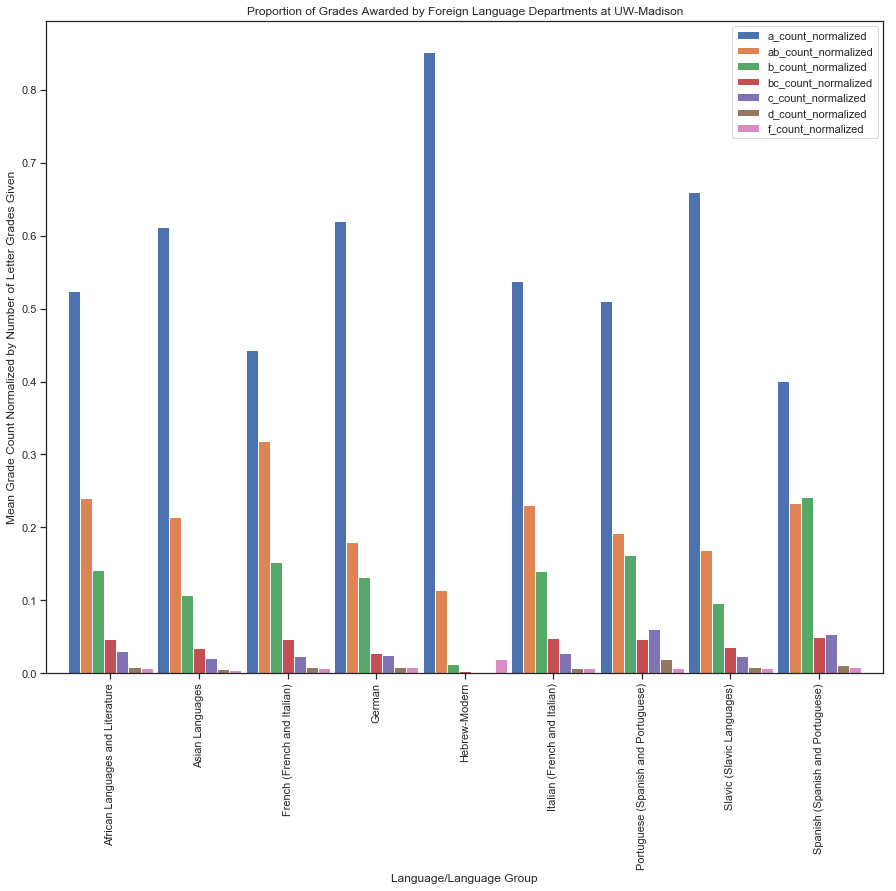

In [341]:
ax = means.drop(columns = ['a_count','ab_count','bc_count','b_count','c_count','d_count','f_count','total_grades','s_count','prop_pass','prop_high','s_count_normalized']).plot.bar(width = 0.95, figsize = (15,12))
ax.set_ylabel('Mean Grade Count Normalized by Number of Letter Grades Given')
ax.set_title('Proportion of Grades Awarded by Foreign Language Departments at UW-Madison')
ax.set_xlabel('Language/Language Group')
plt.show()

Looking at a bar graph of normalized grade count, it appears that more A's are awarded in Hebrew classes than to classes in any other language.  We will look at average class size as well as total number of classes in each foreign langauge to determine whether either of these factors could be influencing the large proportion of A's awarded to Hebrew students.

In [342]:
avg_class_size = df.groupby('subject_name')['total_grades'].mean()

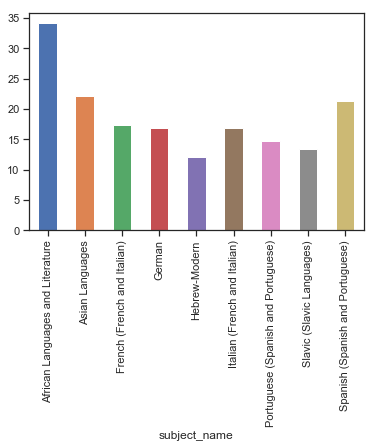

In [343]:
avg_class_size.plot.bar()

Hebrew classes do appear to be smaller than classes in other langauges, but classes in Slavic languages and Portuguese are not much larger on average by comparison. We will check how many total Hebrew classes are in the database. 

In [344]:
num_classes = df.groupby('subject_name').count()

In [345]:
num_classes['total_grades']

subject_name
African Languages and Literature        498
Asian Languages                        1250
French (French and Italian)            1374
German                                  976
Hebrew-Modern                            14
Italian (French and Italian)            698
Portuguese (Spanish and Portuguese)     277
Slavic (Slavic Languages)               441
Spanish (Spanish and Portuguese)       3171
Name: total_grades, dtype: int64

There are only 14 Hebrew classes total.  This sample size is too dissimilar from that of the other languages to obtain reliable results from an ANOVA.  We will exclude Hebrew classes from our analysis.

In [346]:
df_minus_Hebrew= df[df['subject_name'] !='Hebrew-Modern']

In [126]:
means = df_minus_Hebrew.groupby('subject_name').agg('mean')

In [127]:
means.rename({'French (French and Italian)': 'French', 'Italian (French and Italian)': 'Italian', 'Portuguese (Spanish and Portuguese)': 'Portuguese','Slavic (Slavic Languages)':'Slavic Languages', 'Spanish (Spanish and Portuguese)': 'Spanish'},inplace = True)

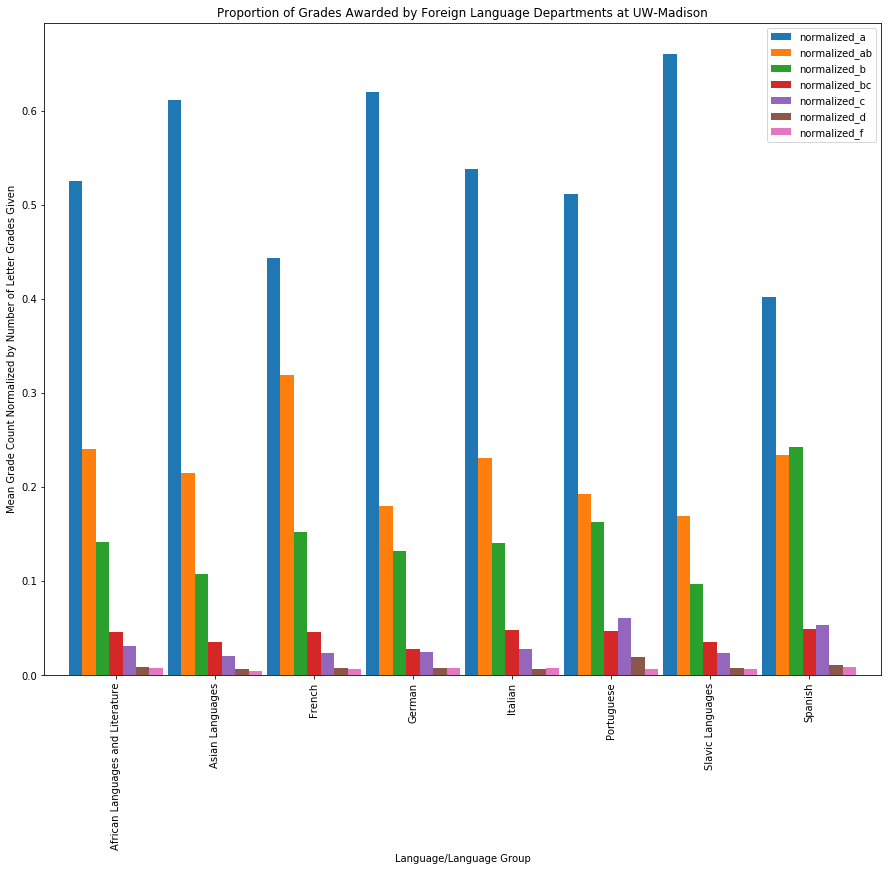

In [176]:
ax = means.drop(columns = ['a_count','ab_count','bc_count','b_count','c_count','d_count','f_count','avg_grade','total_grades']).plot.bar(width = 0.95, figsize = (15,12))
ax.set_ylabel('Mean Grade Count Normalized by Number of Letter Grades Given')
ax.set_title('Proportion of Grades Awarded by Foreign Language Departments at UW-Madison')
ax.set_xlabel('Language/Language Group')
plt.savefig('bar_graph_minus_Hebrew')
plt.show()

ANOVA test requires: 

1) that each sample be drawn from a normally distributed population

2) independent samples

3) equal variances between samples

In order to verify these assumptions, we examine histograms of the proportion of students who passed for each foreign language as well as the proportion of students who made higher than a B in each foreign language.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3b0c0e48>,
      dtype=object)

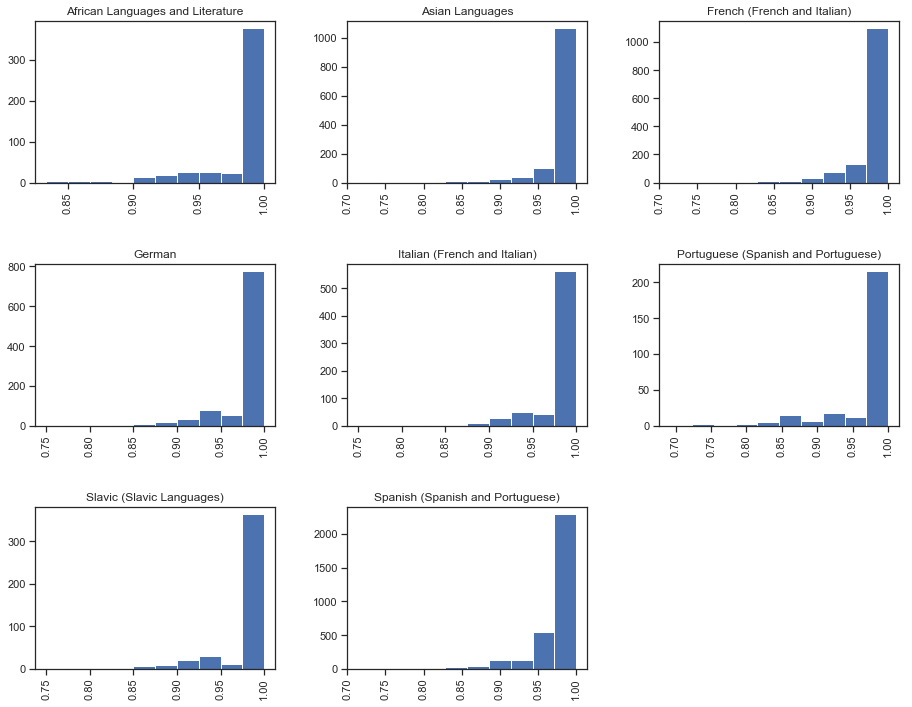

In [347]:
df_minus_Hebrew['prop_pass'].hist(by = df_minus_Hebrew['subject_name'], figsize = (15,12))

A quick look at the histograms of proportion of students who passed makes it clear that these distributions are not normal.  In this case, it would not be appropriate to perform an ANOVA. Instead, we should perform a Kruskal-Wallis test. The hypotheses this test will evaluate are as follows:

H0: There is no difference in proportion of students who pass between the foreign languages

HA: At least one foreign language has a higher or lower proportion of students who pass than the other languages.

In [349]:
subj = df_minus_Hebrew.groupby('subject_name')

In [350]:
scipy.stats.kruskal(*[list(df_minus_Hebrew[df_minus_Hebrew['subject_name']== group]['prop_pass']) for group in subj.groups])

KruskalResult(statistic=69.81605908288448, pvalue=1.6094406697192378e-12)

A p value of 1.6 x 10^-12 indicates there is a significant difference in proportion of students who pass between foreign languages.  Consequently, we reject the null hypothesis that there is no difference in proportion who pass between foreign languages.  In order to determine which foreign language(s) are different from the others, we perform a Games-Howell test.

In [351]:
from pingouin import pairwise_gameshowell
pairwise_gameshowell(dv='prop_pass', between='subject_name', data=df_minus_Hebrew)

,A,B,mean(A),mean(B),diff,SE,tail,T,df,pval,efsize,eftype
0,African Languages and Literature,Asian Languages,0.984,0.989,-0.005,0.001,two-sided,-2.912,816.137,0.654527,-0.154,hedges
1,African Languages and Literature,French (French and Italian),0.984,0.985,-0.001,0.001,two-sided,-0.785,907.121,0.900000,-0.041,hedges
2,African Languages and Literature,German,0.984,0.984,-0.000,0.001,two-sided,-0.212,1063.571,0.900000,-0.012,hedges
3,African Languages and Literature,Italian (French and Italian),0.984,0.985,-0.001,0.001,two-sided,-0.741,1100.103,0.900000,-0.043,hedges
4,African Languages and Literature,Portuguese (Spanish and Portuguese),0.984,0.974,0.010,0.003,two-sided,2.643,383.456,0.141997,0.198,hedges
5,African Languages and Literature,Slavic (Slavic Languages),0.984,0.985,-0.001,0.002,two-sided,-0.419,892.473,0.900000,-0.027,hedges
6,African Languages and Literature,Spanish (Spanish and Portuguese),0.984,0.981,0.003,0.001,two-sided,1.895,700.409,0.499998,0.091,hedges
7,Asian Languages,French (French and Italian),0.989,0.985,0.003,0.001,two-sided,2.887,2608.635,0.659143,0.113,hedges
8,Asian Languages,German,0.989,0.984,0.004,0.001,two-sided,3.242,1860.957,0.658387,0.138,hedges
9,Asian Languages,Italian (French and Italian),0.989,0.985,0.003,0.001,two-sided,2.237,1239.414,0.329486,0.106,hedges


Fewer students appear to pass Portuguese than classes in most other langauges, given the low p-values of the pairwise comparisons between Portuguese and other languages. 

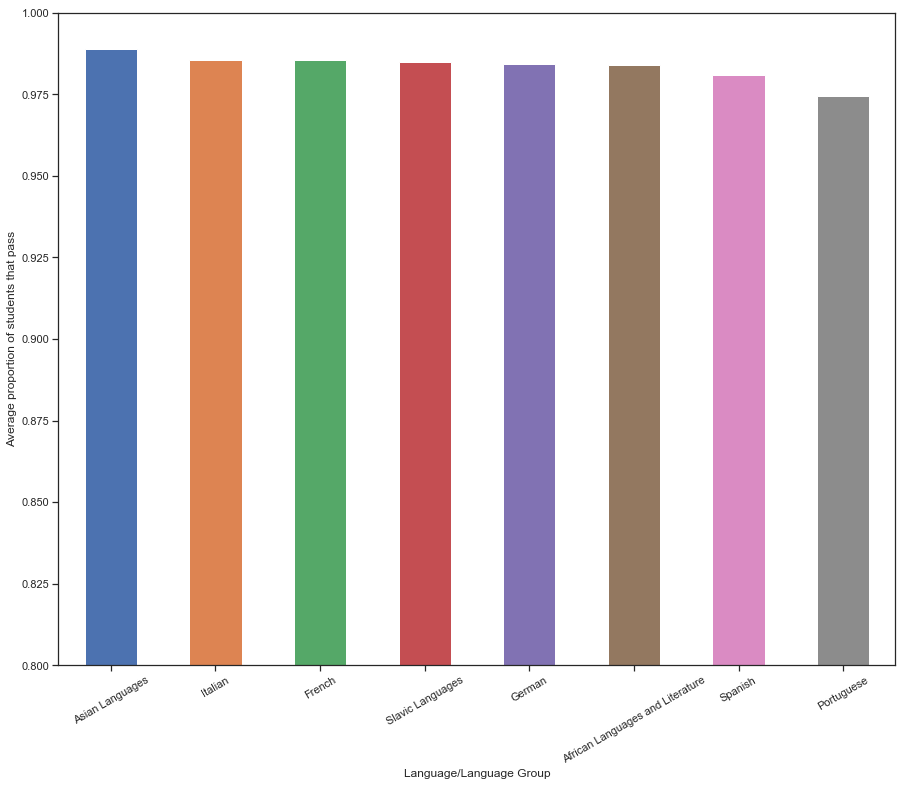

In [383]:
pas = df_minus_Hebrew.groupby('subject_name')['prop_pass'].agg('mean').sort_values(ascending =False)
pas.rename({'French (French and Italian)': 'French', 'Italian (French and Italian)': 'Italian', 'Portuguese (Spanish and Portuguese)': 'Portuguese','Slavic (Slavic Languages)':'Slavic Languages', 'Spanish (Spanish and Portuguese)': 'Spanish'},inplace = True)
ax = pas.plot.bar(figsize = (15,12),ylim = (0.8,1))
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation = 30)
ax.set_xlabel('Language/Language Group')
ax.set_ylabel('Average proportion of students that pass')
plt.savefig('prop_pass')

Next we will evaluate the proportion of students who earn a B or better in each foreign language to get a more complete sense of which language students perform better in.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3bb1c5f8>,
      dtype=object)

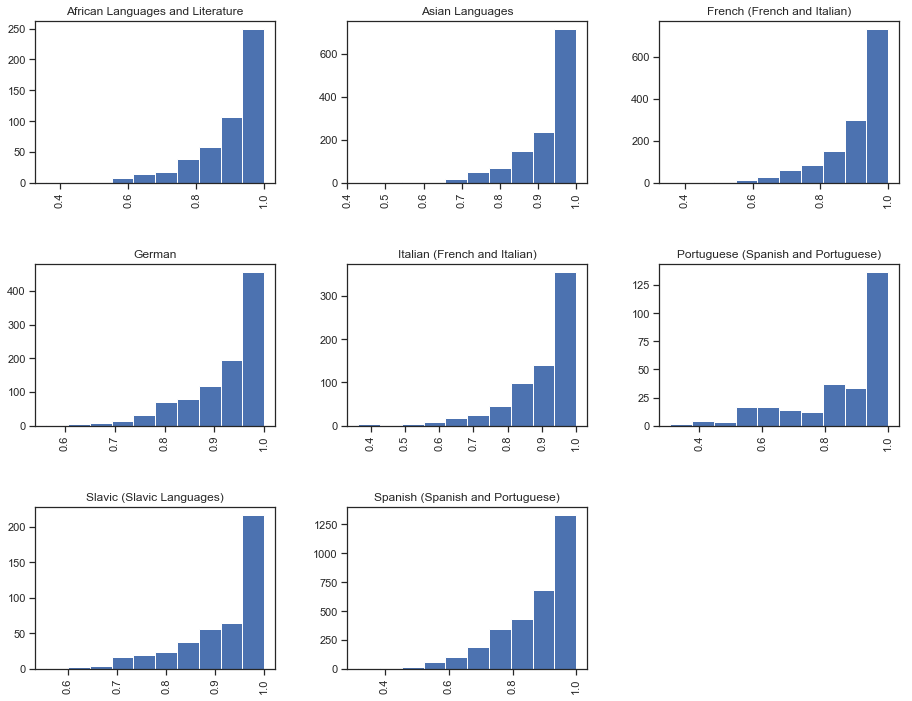

In [348]:
df_minus_Hebrew['prop_high'].hist(by = df_minus_Hebrew['subject_name'], figsize = (15,12))

The proportion of students who earn a B or better is not normally distributed, so we must perform a Kruskal-Wallis test to determine whether one foreign language has a different proportion than the others. The hypotheses we will test are:

H0: There is no difference in the proportion of students who earn a B or better between foreign languages at UW-Madison

HA: At least one foreign language has a different proportion of students who earn a B or better than the other foreign languages taught at UW-Madison

In [355]:
scipy.stats.kruskal(*[list(df_minus_Hebrew[df_minus_Hebrew['subject_name']== group]['prop_high']) for group in subj.groups])

KruskalResult(statistic=360.09627417053355, pvalue=8.492223532306688e-74)

A p-value of 8.5 x 10^-74 suggests we should reject the null hypothesis that there is no difference in the proportion of students who earn a B or better between foreign language.  We will perform a Games-Howell test to investigate which foreign languages are different.

In [352]:
from pingouin import pairwise_gameshowell
pairwise_gameshowell(dv='prop_high', between='subject_name', data=df_minus_Hebrew)

,A,B,mean(A),mean(B),diff,SE,tail,T,df,pval,efsize,eftype
0,African Languages and Literature,Asian Languages,0.907,0.934,-0.027,0.004,two-sided,-4.856,744.406,0.001000,-0.257,hedges
1,African Languages and Literature,French (French and Italian),0.907,0.915,-0.008,0.004,two-sided,-1.420,814.874,0.499999,-0.074,hedges
2,African Languages and Literature,German,0.907,0.932,-0.025,0.004,two-sided,-4.405,788.037,0.001000,-0.242,hedges
3,African Languages and Literature,Italian (French and Italian),0.907,0.909,-0.002,0.005,two-sided,-0.358,1049.192,0.900000,-0.021,hedges
4,African Languages and Literature,Portuguese (Spanish and Portuguese),0.907,0.866,0.041,0.008,two-sided,3.633,415.778,0.007061,0.272,hedges
5,African Languages and Literature,Slavic (Slavic Languages),0.907,0.926,-0.019,0.005,two-sided,-2.889,933.170,0.655464,-0.189,hedges
6,African Languages and Literature,Spanish (Spanish and Portuguese),0.907,0.877,0.029,0.004,two-sided,5.393,692.030,0.001000,0.260,hedges
7,Asian Languages,French (French and Italian),0.934,0.915,0.019,0.003,two-sided,5.152,2608.757,0.001000,0.201,hedges
8,Asian Languages,German,0.934,0.932,0.002,0.003,two-sided,0.565,2125.079,0.900000,0.024,hedges
9,Asian Languages,Italian (French and Italian),0.934,0.909,0.025,0.003,two-sided,5.190,1196.068,0.001000,0.245,hedges


The results of the Games-Howell test suggest that slightly fewer A's and B's are awarded to Spanish and Portuguese classes than classes in most other foreign languages at UW-Madison. In addition, slightly more A's and B's are awarded to German and Asian language classes than to African language and Italian classes; most of the other foreign languages fall between Spanish/Portuguese and German/Asian languages in terms of proportion of students who earn A's and B's.

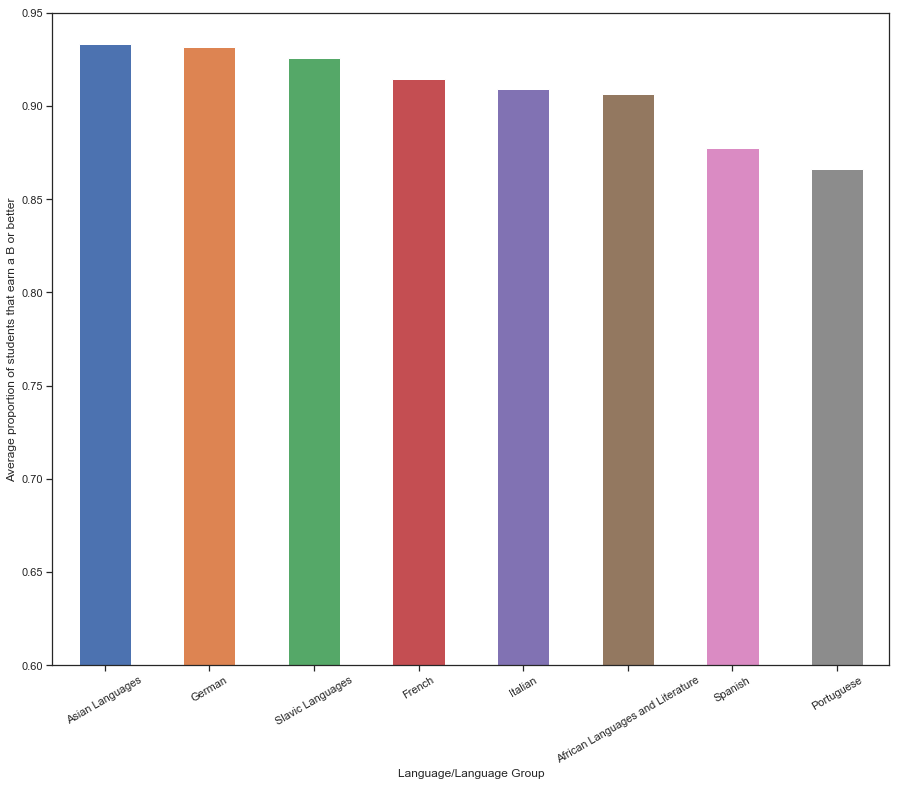

In [385]:
high = df_minus_Hebrew.groupby('subject_name')['prop_high'].agg('mean').sort_values(ascending = False)
high.rename({'French (French and Italian)': 'French', 'Italian (French and Italian)': 'Italian', 'Portuguese (Spanish and Portuguese)': 'Portuguese','Slavic (Slavic Languages)':'Slavic Languages', 'Spanish (Spanish and Portuguese)': 'Spanish'},inplace = True)
ax = high.plot.bar(figsize = (15,12), ylim = (0.6,0.95))
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation = 30)
ax.set_xlabel('Language/Language Group')
ax.set_ylabel('Average proportion of students that earn a B or better')
plt.savefig('prop_high')

Subsequently, we investigate whether the room a course is taught in influences grades earned in the class. We begin by querying the database for information regarding room a course is taught in, grades earned in each class, and instructors for each class.

# SQL Queries

In [4]:
q = ("select * from sections")
sections =  pd.read_sql_query(q, conn)

q = ("select * from rooms")
rooms = pd.read_sql_query(q, conn)

q = ('select * from grade_distributions')
grade_distributions = pd.read_sql_query(q, conn)

q = ("select * from rooms r JOIN sections s WHERE r.uuid = s.room_uuid")
rooms_sections = pd.read_sql_query(q, conn)
     
q = ("select * from course_offerings")
course_offerings = pd.read_sql_query(q, conn)

q = ("select * from teachings")
teachings = pd.read_sql_query(q, conn)

q = ("select * from instructors")
instructors = pd.read_sql_query(q, conn)

# Data Cleaning

In [5]:
#renaming columns
course_offerings.rename(columns={'uuid':'course_offering_uuid'}, inplace=True)
instructors.columns = ['instructor_id', 'instructor_name']
rooms_sections.columns= ['room_uuid', 'facility_code', 'room_code', 'section_uuid', 'course_offering_uuid',
       'section_type', 'number', 'room_uuid2', 'schedule_uuid']

#drop columns
rooms_sections.drop('room_uuid2', axis=1, inplace=True)

#merge dataframes
df = rooms_sections.merge(grade_distributions, on='course_offering_uuid').merge(course_offerings, 
        on ='course_offering_uuid').merge(teachings, on ='section_uuid').merge(instructors, on = 'instructor_id')

#convert key values to numeric
for index, column in enumerate(df.iloc[:,8:-5]):
    df.iloc[:,(8+index)] = pd.to_numeric(df.iloc[:,(8+index)])
    
#drop rows where no grades
df.drop(df.loc[(df['a_count']==0) & (df['b_count']==0) & (df['c_count']==0) & (df['d_count']==0) & (df['f_count']==0) & (df['ab_count']==0)].index, inplace=True)

#drop rows where there are five or less grades
df.drop(df.loc[(df['a_count'] + df['b_count'] + df['c_count'] + df['d_count'] + df['f_count'] + df['ab_count']) <= 5].index, inplace= True)

#drop rows where room_code is 'null'
df.drop(df.loc[df['room_code']=='null'].index, inplace =True)


### Begin investigation with aim of finding two classrooms to focus on.

In [6]:
#drop the bottom quartile of rooms
#np.quantile(df['room_code'].value_counts(),.25)
num_rooms_to_drop = round(len(df.room_code.value_counts())*.25)
room_subset = [room for room in df['room_code'].value_counts().index[:-num_rooms_to_drop]]
df = df[df['room_code'].isin(room_subset)]

#df.instructor_id.value_counts().describe()
#np.quantile(df['instructor_id'].value_counts(),.99)
#np.quantile(df['instructor_id'].value_counts(),.25)

high_cutoff = round(len(df.room_code.value_counts())*.99)
low_cutoff = round(len(df.room_code.value_counts())*.25)

#  Grab a smaller subset of instructors, defined by the quantile range between .75 and .99 
#  of number of times the instructor appears in the dataframe.

instructors_subset = [instructor for instructor in df.instructor_id.unique()]
df = df[df.instructor_id.isin(instructors_subset[low_cutoff:high_cutoff])]

In [7]:
#Create a groupby object grouping by room, course, and instructor
df_groups = df.groupby(['room_code', 'course_uuid', 'instructor_id'])

group_names = []
for name, groups in df_groups:
    group_names.append(name)
    
#rename a columnn
df.rename(columns={'name':'course_name'}, inplace=True)

In [8]:
#list of the keys for the groupby object
group_names[0]

('0010', '0f028eba-ac26-36d3-b6f1-c18a72303e74', '3493329')

In [9]:
print(len(group_names), " - this is the number of unique room, course, and teacher groupings in the groupby object.")

3237  - this is the number of unique room, course, and teacher groupings in the groupby object.


In [10]:
#example of one group in the group by object
df_groups.get_group(group_names[0]).head(5)

,room_uuid,facility_code,room_code,section_uuid,course_offering_uuid,section_type,number,schedule_uuid,section_number,n_count,...,a_count,s_count,i_count,b_count,nr_count,course_uuid,term_code,course_name,instructor_id,instructor_name
64037,f5bb3122-3653-3d4c-aec0-cd574c99420f,0070,0010,dbada0b2-0524-345d-83ee-dbfac60776b1,f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9,LEC,5,22b99e69-ae34-3577-bf01-899774ba3047,1,0,...,9,0,0,3,0,0f028eba-ac26-36d3-b6f1-c18a72303e74,1174,Science and Storytelling,3493329,JOSEPH QUICK
64038,f5bb3122-3653-3d4c-aec0-cd574c99420f,0070,0010,dbada0b2-0524-345d-83ee-dbfac60776b1,f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9,LEC,5,22b99e69-ae34-3577-bf01-899774ba3047,2,0,...,7,0,0,1,0,0f028eba-ac26-36d3-b6f1-c18a72303e74,1174,Science and Storytelling,3493329,JOSEPH QUICK
64039,f5bb3122-3653-3d4c-aec0-cd574c99420f,0070,0010,dbada0b2-0524-345d-83ee-dbfac60776b1,f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9,LEC,5,22b99e69-ae34-3577-bf01-899774ba3047,3,0,...,4,0,0,4,0,0f028eba-ac26-36d3-b6f1-c18a72303e74,1174,Science and Storytelling,3493329,JOSEPH QUICK
64040,f5bb3122-3653-3d4c-aec0-cd574c99420f,0070,0010,dbada0b2-0524-345d-83ee-dbfac60776b1,f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9,LEC,5,22b99e69-ae34-3577-bf01-899774ba3047,4,0,...,10,0,0,2,0,0f028eba-ac26-36d3-b6f1-c18a72303e74,1174,Science and Storytelling,3493329,JOSEPH QUICK
64041,f5bb3122-3653-3d4c-aec0-cd574c99420f,0070,0010,dbada0b2-0524-345d-83ee-dbfac60776b1,f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9,LEC,5,22b99e69-ae34-3577-bf01-899774ba3047,5,0,...,6,0,0,1,0,0f028eba-ac26-36d3-b6f1-c18a72303e74,1174,Science and Storytelling,3493329,JOSEPH QUICK


In [11]:
#calculates the ratio of the grade give rather than just the count
df_rci = pd.DataFrame(columns=['room_code','course_name','instructor_name', 'A','AB','B','C','D','F','room_uuid','course_uuid','instructor_id','term_code'])

#iterate through each of the groups
for index, group in enumerate(group_names):
    
    if df_groups.get_group(group_names[index]).shape[0]>=10:
        #iterate through each row in the current group
        hold_df = pd.DataFrame(columns=['room_code','course_name','instructor_name', 'A','AB','B','C','D','F','room_uuid','course_uuid','instructor_id','term_code'])
        for row_index in range(df_groups.get_group(group_names[index]).shape[0]):
            #take a sum across the row
            row_sum = np.array(df_groups.get_group(group_names[index]).iloc[row_index][['a_count','ab_count','b_count','c_count','d_count','f_count']]).sum()
            
            #update each grade count with ratio representing that grade count divided by the sum of all grades given across that row
            #df_groups.get_group(group_names[index]).loc[row_index] = [
            hold_df.loc[row_index] = [
                    
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['room_code'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['course_name'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['instructor_name'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['a_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['ab_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['b_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['c_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['d_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['f_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['room_uuid'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['course_uuid'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['instructor_id'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['term_code']
                
                
                                                                            ]
        
        #append a row to a new dataframe containing arrays of ratios
        df_rci.loc[index] = [
                                hold_df['room_code'][0],
                                hold_df['course_name'][0],
                                hold_df['instructor_name'][0],
                                hold_df['A'],
                                hold_df['AB'],
                                hold_df['B'],
                                hold_df['C'],
                                hold_df['D'],
                                hold_df['F'],
                                hold_df['room_uuid'][0],
                                hold_df['course_uuid'][0],
                                hold_df['instructor_id'][0],
                                hold_df['term_code'][0]
                                
                            ]

#df_rci.rename(columns={'couse_uuid' : 'course_uuid'}, inplace=True)

#now regroup by room and course counts
rc_df = df_rci.groupby(['room_code','course_uuid']).count()

### Selecting classrooms to focus on

In [12]:
rc_df.loc[rc_df['A']>30]

,,course_name,instructor_name,A,AB,B,C,D,F,room_uuid,instructor_id,term_code
room_code,course_uuid,,,,,,,,,,,
2170,fc10f135-3e48-3b54-ad16-e551abb3a85a,32,32,32,32,32,32,32,32,32,32,32
2190,fc10f135-3e48-3b54-ad16-e551abb3a85a,40,40,40,40,40,40,40,40,40,40,40
4013,7a552326-da08-354c-aafc-f56edcf83f44,38,38,38,38,38,38,38,38,38,38,38
4018,7a552326-da08-354c-aafc-f56edcf83f44,42,42,42,42,42,42,42,42,42,42,42


In [13]:
#create a key for the rooms and courses groupby object
room_course_list = list(rc_df.loc[rc_df['A']>30].index)
room_course_list

[('2170', 'fc10f135-3e48-3b54-ad16-e551abb3a85a'),
 ('2190', 'fc10f135-3e48-3b54-ad16-e551abb3a85a'),
 ('4013', '7a552326-da08-354c-aafc-f56edcf83f44'),
 ('4018', '7a552326-da08-354c-aafc-f56edcf83f44')]

In [14]:
#now regroup by room and course sans count()
df_rc = df_rci.groupby(['room_code','course_uuid'])

In [15]:
#make lists of instructors in each room and count those lists
instructors_2170 = list(df_rc.get_group(room_course_list[0])['instructor_id'])
instructors_2190 = list(df_rc.get_group(room_course_list[1])['instructor_id'])
print(len(instructors_2170), len(instructors_2190), len(set(instructors_2170 + instructors_2190)))

32 40 64


In [39]:
df_rc.get_group(room_course_list[0]).head(2)

,room_code,course_name,instructor_name,A,AB,B,C,D,F,room_uuid,course_uuid,instructor_id,term_code
1356,2170,Intro Financial Accounting,DANIEL WANGERIN,0 0.212121 1 0.233333 2 0.250000 3...,0 0.000000 1 0.133333 2 0.125000 3...,0 0.363636 1 0.200000 2 0.406250 3...,0 0.242424 1 0.066667 2 0.156250 3...,0 0.151515 1 0.266667 2 0.031250 3...,0 0.030303 1 0.100000 2 0.031250 3...,026d4b38-9cc3-361d-af8d-ef162119f51e,fc10f135-3e48-3b54-ad16-e551abb3a85a,1546260,1094
1357,2170,Intro Financial Accounting,MATTHEW JUNEMANN,0 0.212121 1 0.233333 2 0.250000 3...,0 0.000000 1 0.133333 2 0.125000 3...,0 0.363636 1 0.200000 2 0.406250 3...,0 0.242424 1 0.066667 2 0.156250 3...,0 0.151515 1 0.266667 2 0.031250 3...,0 0.030303 1 0.100000 2 0.031250 3...,026d4b38-9cc3-361d-af8d-ef162119f51e,fc10f135-3e48-3b54-ad16-e551abb3a85a,1552615,1094


Text(0.5, 0, "Percent A's Given")

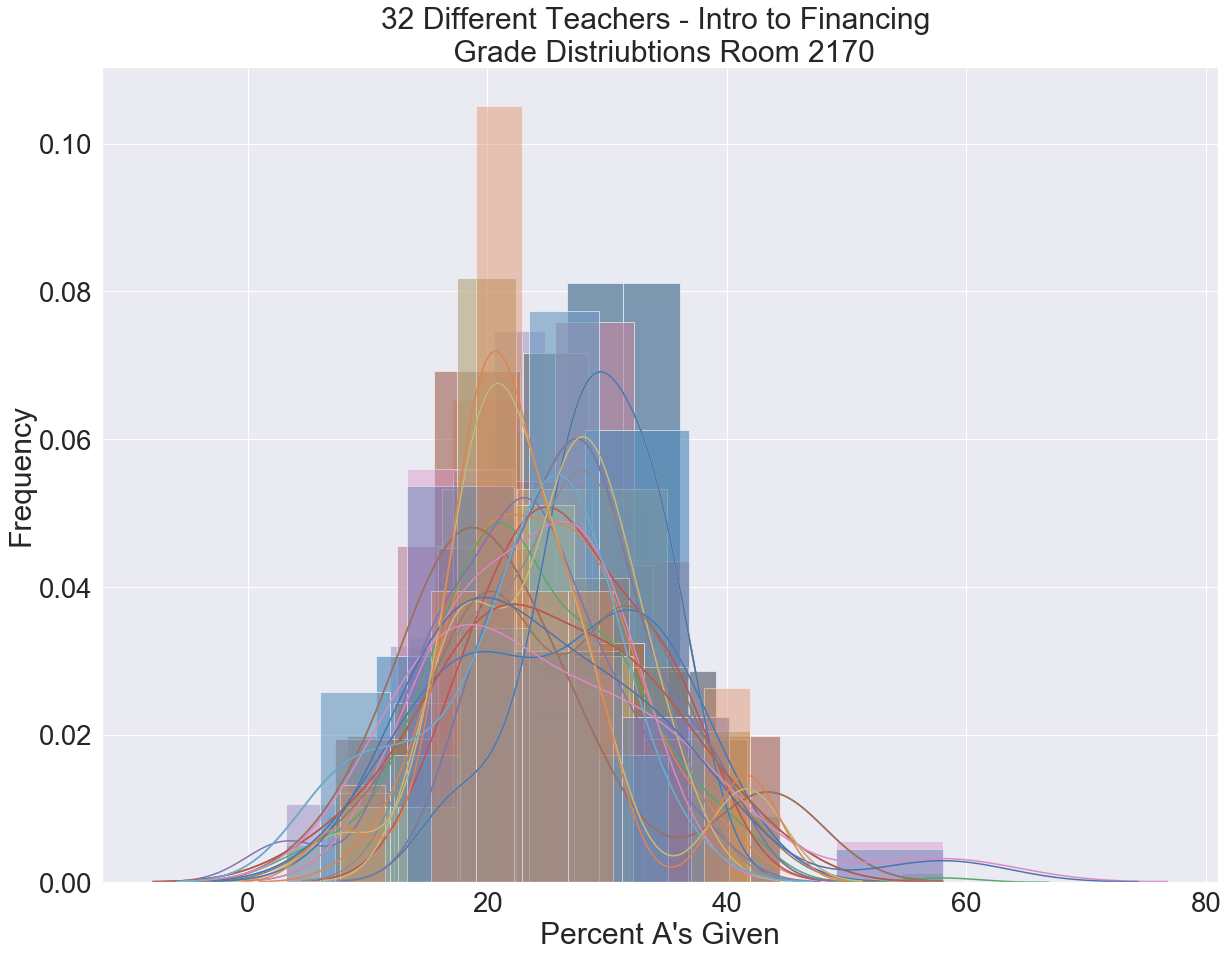

In [60]:
#Seaborn distplot of room 2170 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)

fig, ax = plt.subplots(figsize=(20,15))
for row in range(df_rc.get_group(room_course_list[0]).shape[0]):
    sns.distplot(df_rc.get_group(room_course_list[0]).iloc[row]['A']*100, label=df_rc.get_group(room_course_list[0]).iloc[row]['instructor_name'].split()[1],  ax = ax)
    
ax.set_title("32 Different Teachers - Intro to Financing \n Grade Distriubtions Room 2170")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent A's Given")



Text(0.5, 0, "Percent A's Given")

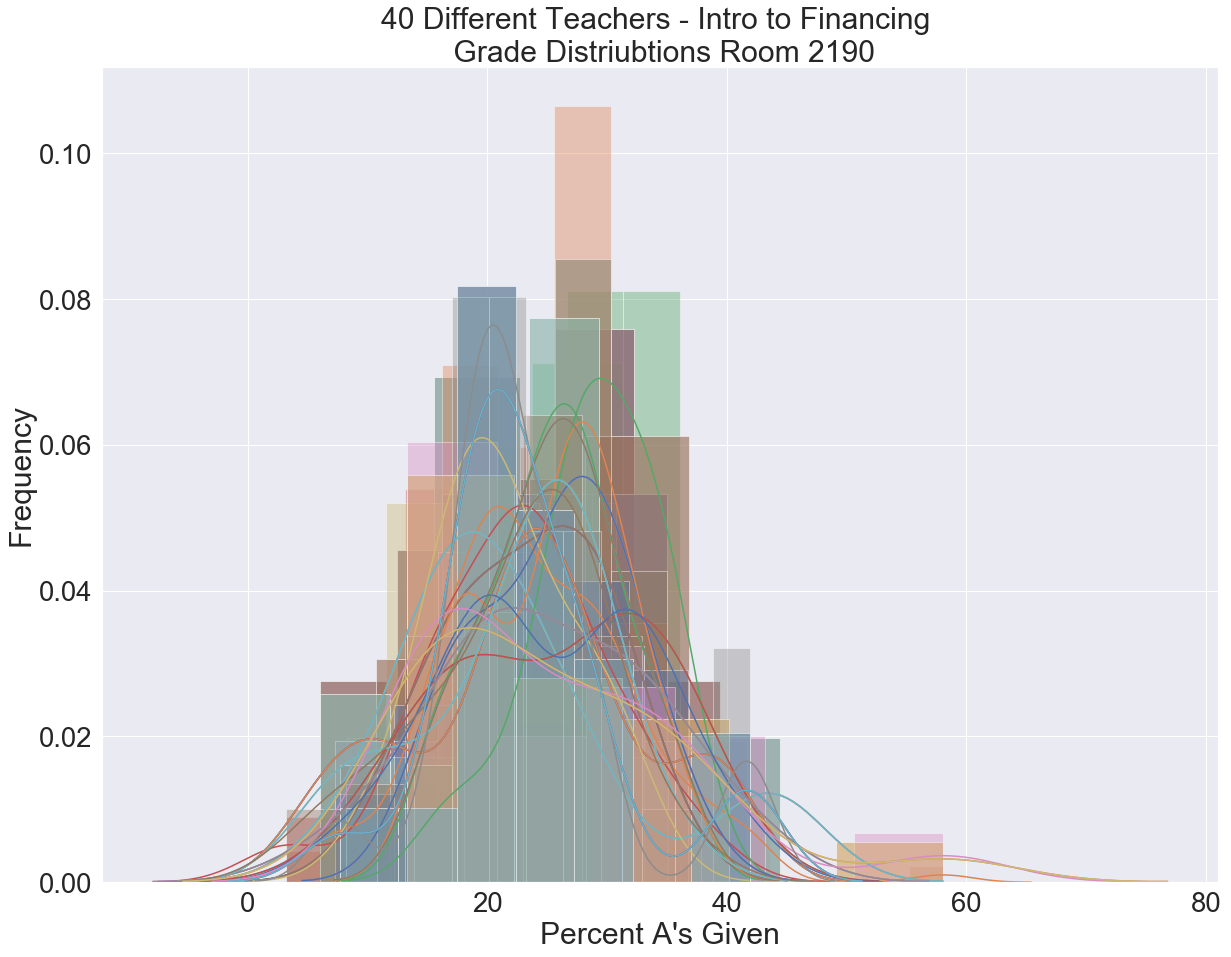

In [49]:
#Seaborn distplot of room 2190 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(20,15))
for row in range(df_rc.get_group(room_course_list[1]).shape[0]):
    sns.distplot(df_rc.get_group(room_course_list[1]).iloc[row]['A']*100, label=df_rc.get_group(room_course_list[1]).iloc[row]['room_code'],  ax = ax)
    
ax.set_title("40 Different Teachers - Intro to Financing \n Grade Distriubtions Room 2190")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent A's Given")

In [80]:
#Make a master array for each room
Financing_2190 = []
for row in range(df_rc.get_group(room_course_list[1]).shape[0]):
    Financing_2190+=list(df_rc.get_group(room_course_list[1]).iloc[row]['A']*100)

Financing_2170 = []
for row in range(df_rc.get_group(room_course_list[0]).shape[0]):
    Financing_2170+=list(df_rc.get_group(room_course_list[0]).iloc[row]['A']*100)

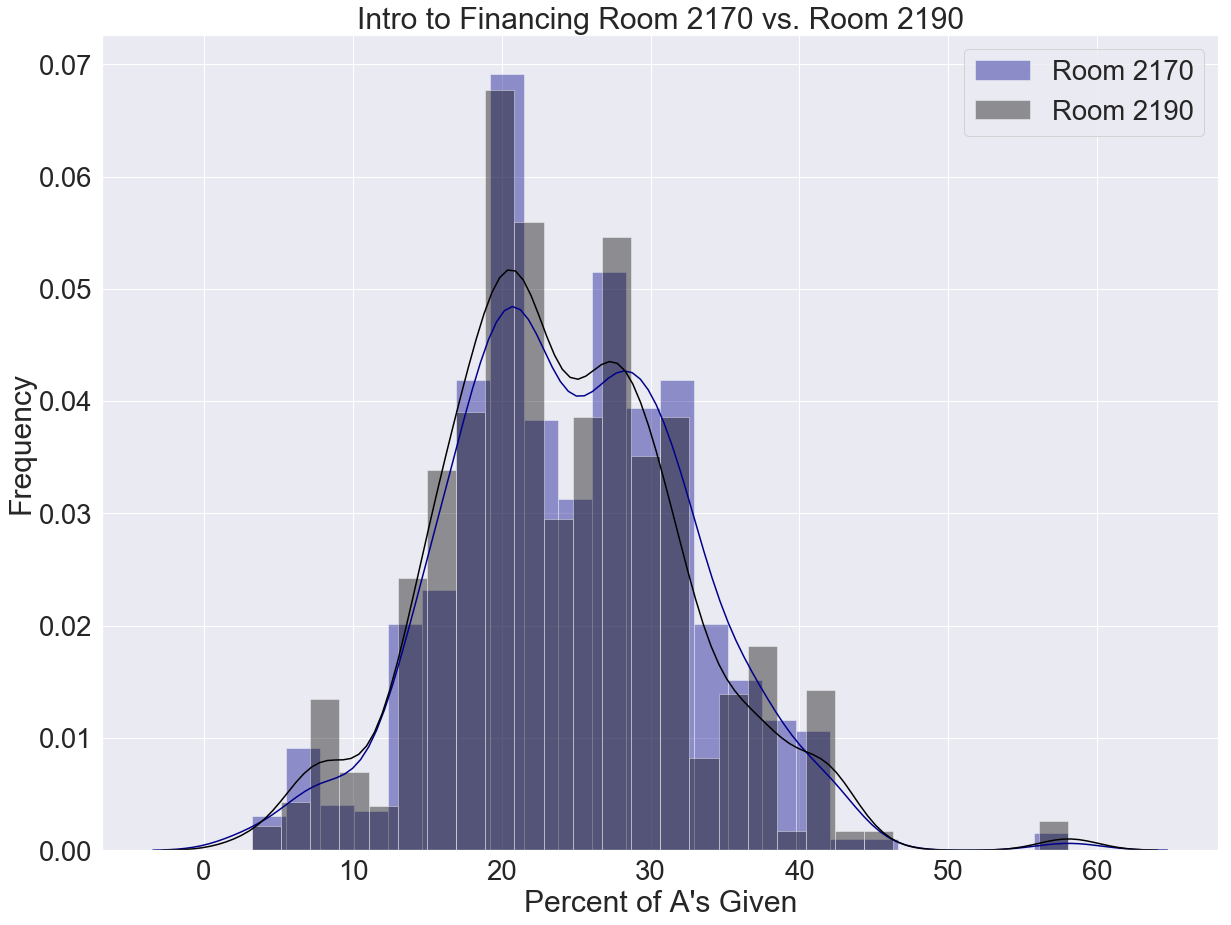

In [81]:
sns.set_style('whitegrid')
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Financing_2170,  ax = ax, color='darkblue', label='Room 2170')
sns.distplot(Financing_2190,  ax = ax, color='black', label='Room 2190')
    
ax.set_title("Intro to Financing Room 2170 vs. Room 2190")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent of A's Given")
ax.legend()


In [82]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Financing_2170
y = Financing_2190
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {round(ttest[1],2)}')
print('The test fails to reject the null at the .05 level of significance.')
print('The effect size is: ', round(abs(np.array(Financing_2170).mean()-np.array(Financing_2190).mean()),8))

The p-value for the two sided independent t test is:  0.12
The test fails to reject the null at the .05 level of significance.
The effect size is:  0.57511578


In [97]:
print('The mean of room 2170 is: ', round(np.array(Financing_2170).mean(),2), '%\nThe mean of room 2190 is: ', round(np.array(Financing_2190).mean(),2),'%')


The mean of room 2170 is:  23.98 %
The mean of room 2190 is:  24.01 %


### Now looking again only with the same instructors in each room

In [22]:
#Create a new dataframe for each room
df_2170 = df_rc.get_group(room_course_list[0])
df_2190 = df_rc.get_group(room_course_list[1])

#Delete instructors that are not in both rooms
df_2190 = df_2190[df_2190.instructor_id.isin(instructors_2170)]
instructors_2190 = list(df_2190['instructor_id'])
df_2170 = df_2170[df_2170.instructor_id.isin(instructors_2190)]

Text(0.5, 0, "Percentage of A's given")

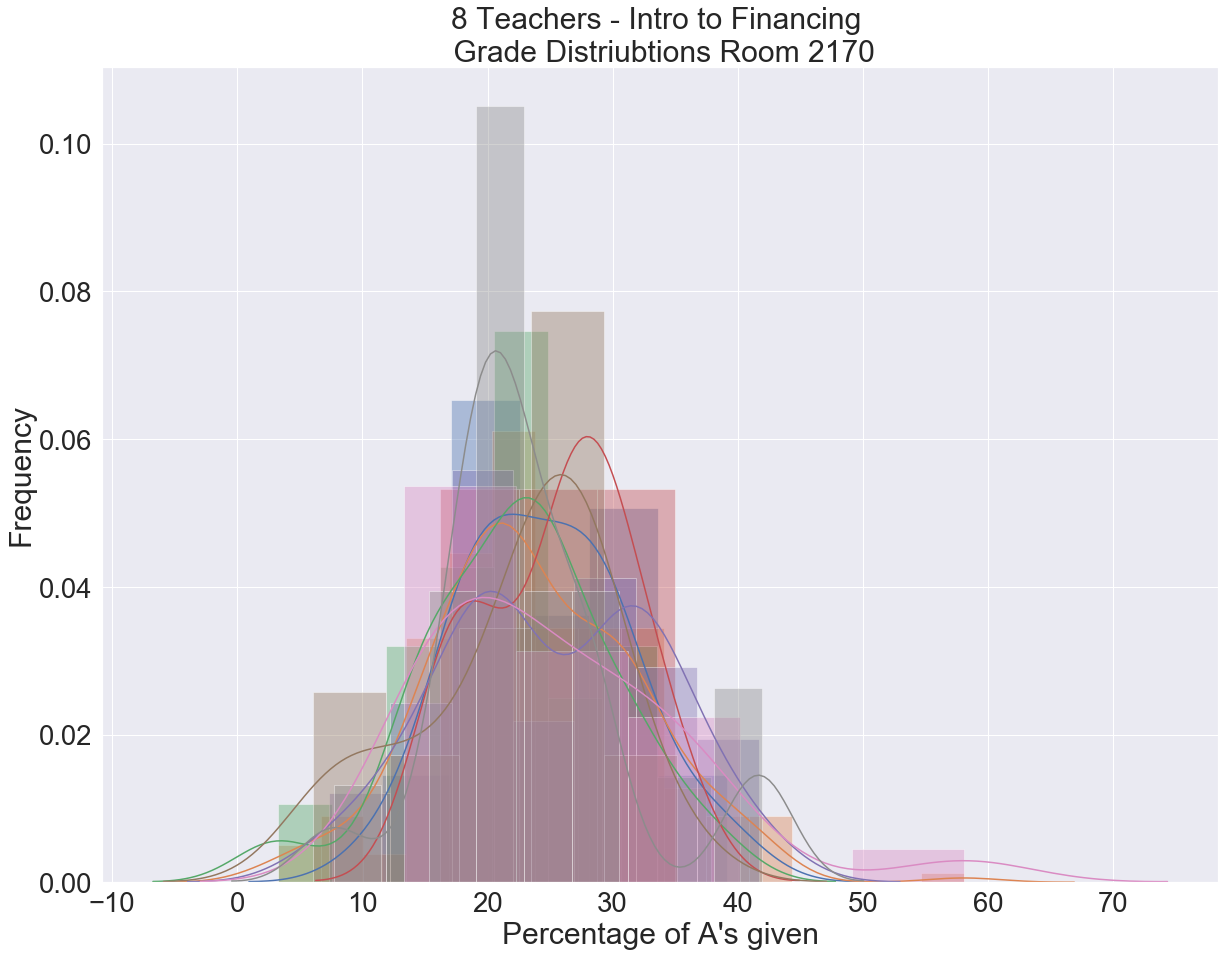

In [85]:
#Seaborn distplot of room 2170 Intro to Finance with only the 8 teachers that also have sections in room 2190
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))
#ax.title("32 Different Teachers - Intro to Financing - Grade Distriubtions Room 2170")
for row in range(df_2170.shape[0]):
    sns.distplot(df_2170.iloc[row]['A']*100,label=df_rc.get_group(room_course_list[0]).iloc[row]['instructor_name'],  ax = ax)
    
ax.set_title("8 Teachers - Intro to Financing \n Grade Distriubtions Room 2170")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's given")
#ax.legend()

Text(0.5, 0, "Percentage of A's Given")

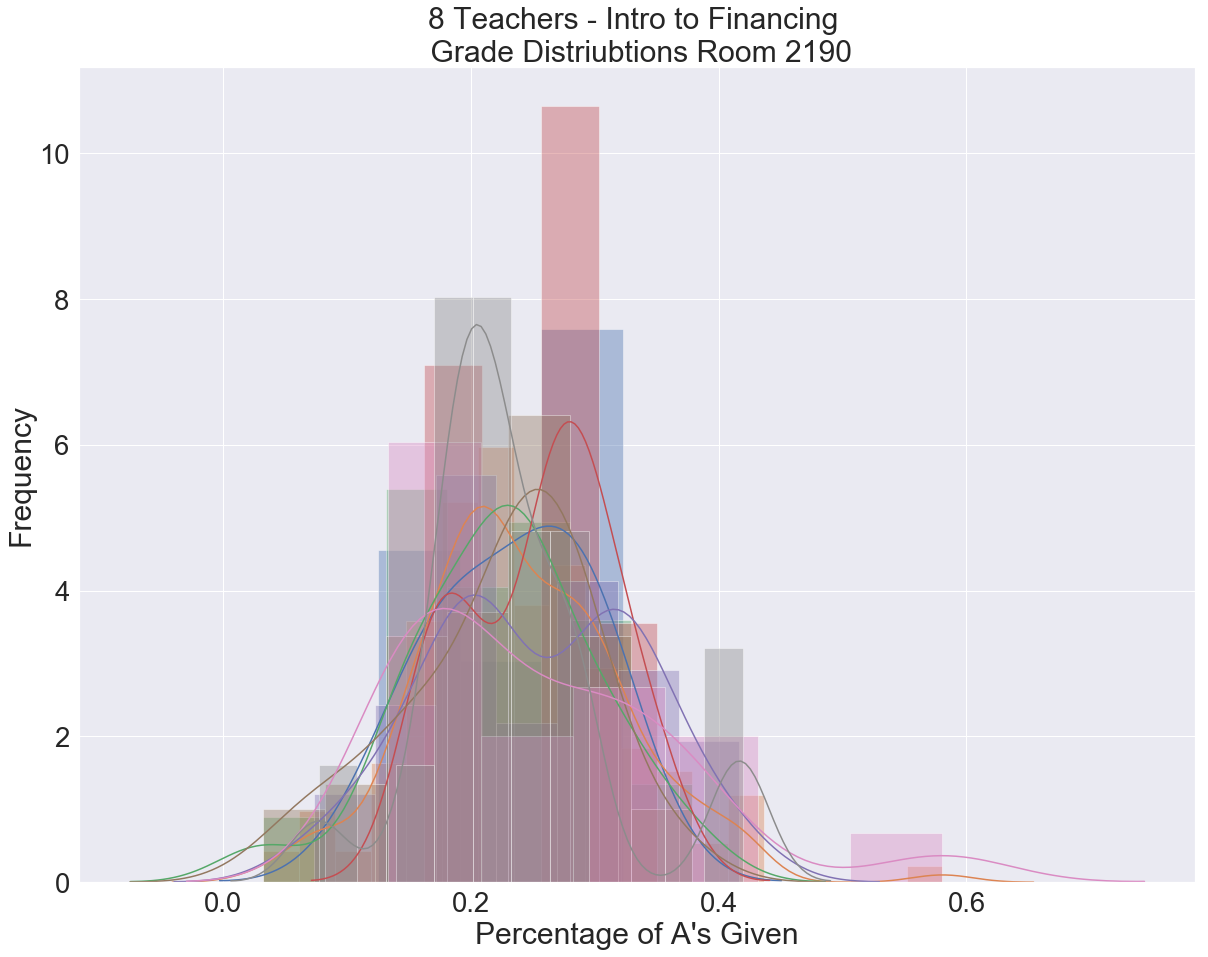

In [86]:
#Seaborn distplot of room 2190 Intro to Finance with only the 8 teachers that also have sections in room 2170
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,15))
#ax.title("32 Different Teachers - Intro to Financing - Grade Distriubtions Room 2170")
for row in range(df_2190.shape[0]):
    sns.distplot(df_2190.iloc[row]['A'], label=df_2190.iloc[row]['room_code'],  ax = ax)
    
ax.set_title("8 Teachers - Intro to Financing \n Grade Distriubtions Room 2190")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's Given")

### Now looking at the classrooms as a whole - sections/teachers melted together

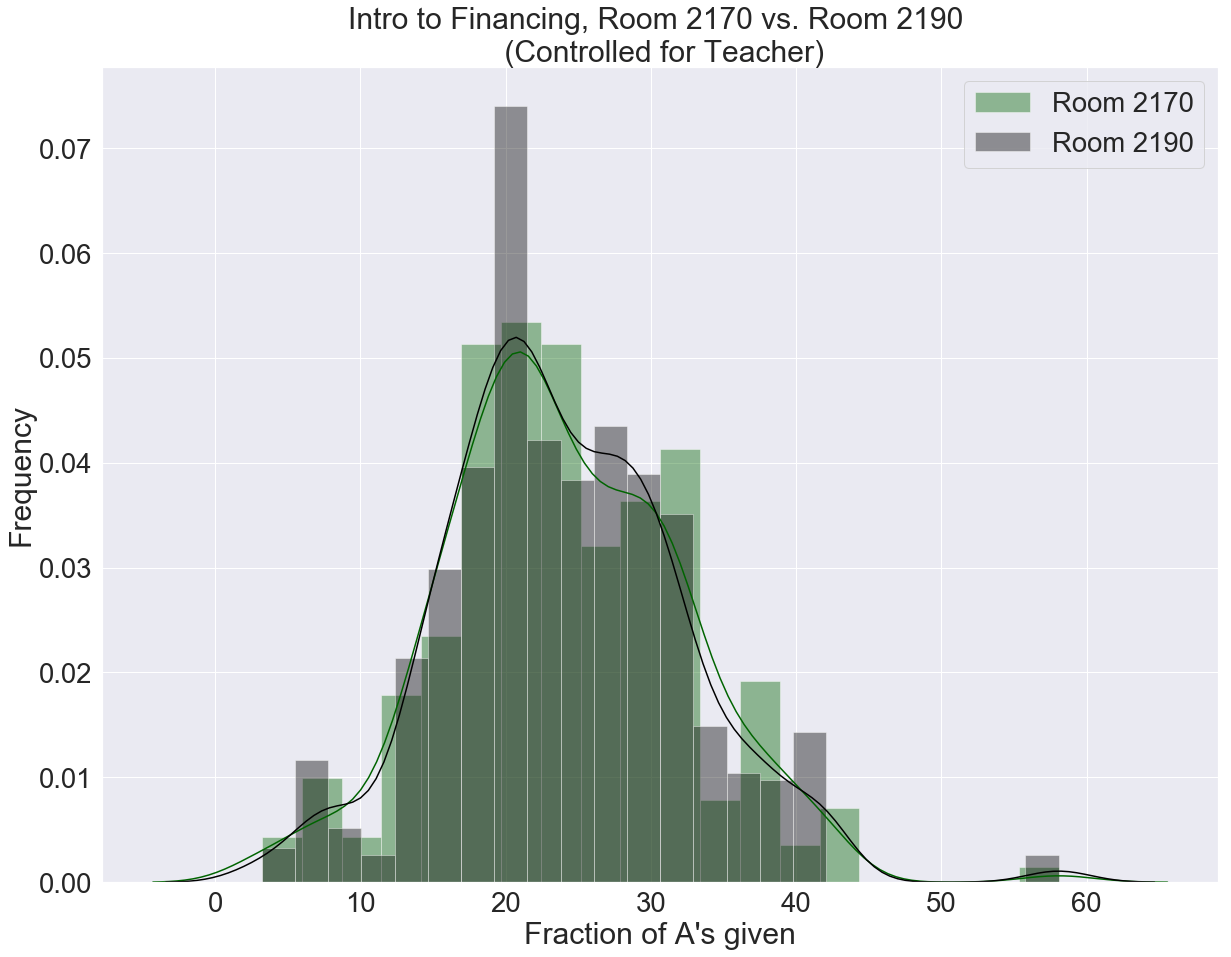

In [90]:


Financing_2170 = []
for row in range(df_2170.shape[0]):
    Financing_2170+=list(df_2170.iloc[row]['A']*100)
#Financing_2170

Financing_2190 = []
for row in range(df_2190.shape[0]):
    Financing_2190+=list(df_2190.iloc[row]['A']*100)
#Financing_2190

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Financing_2170,  ax = ax, color='darkgreen', label='Room 2170')
sns.distplot(Financing_2190,  ax = ax, color='black', label='Room 2190')
    
ax.set_title("Intro to Financing, Room 2170 vs. Room 2190 \n (Controlled for Teacher)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")
ax.legend()


### Two sided independent ttest on the distributions of ratio of A's given for the two classrooms

In [101]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Financing_2170
y = Financing_2190
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {ttest[1]}')
print('The test fails to reject the null at the .05 level of significance.')
print('The effect size is: ', round(abs(np.array(Financing_2170).mean()-np.array(Financing_2190).mean()),8))

The p-value for the two sided independent t test is:  0.9491947471090479
The test fails to reject the null at the .05 level of significance.
The effect size is:  0.030802


In [100]:
print('The mean of room 2170 is: ', round(np.array(Financing_2170).mean(),2), '%\nThe mean of room 2190 is: ', round(np.array(Financing_2190).mean(),2),'%')


The mean of room 2170 is:  23.98 %
The mean of room 2190 is:  24.01 %


### Now looking at two new classrooms

In [27]:
df_4013 = df_rc.get_group(room_course_list[2])
df_4018 = df_rc.get_group(room_course_list[3])

instructors_4013 = list(df_4013['instructor_id'])
instructors_4018 = list(df_4018['instructor_id'])

Text(0.5, 0, "Fraction of A's given")

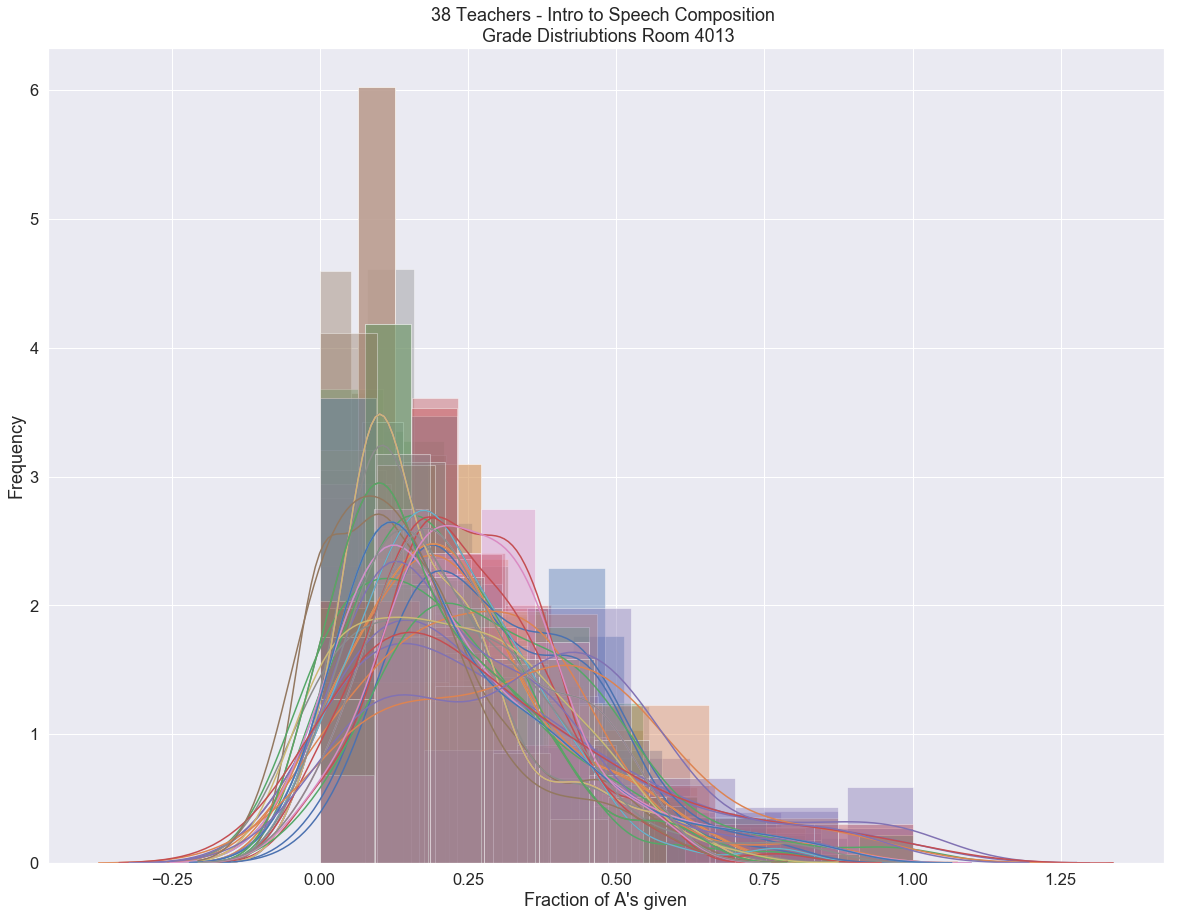

In [28]:
#Seaborn distplot of room 4013 Speech Composition
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4013.shape[0]):
    sns.distplot(df_4013.iloc[row]['A'],  ax = ax)
    
ax.set_title("38 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4013")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")

Text(0.5, 0, "Fraction of A's given")

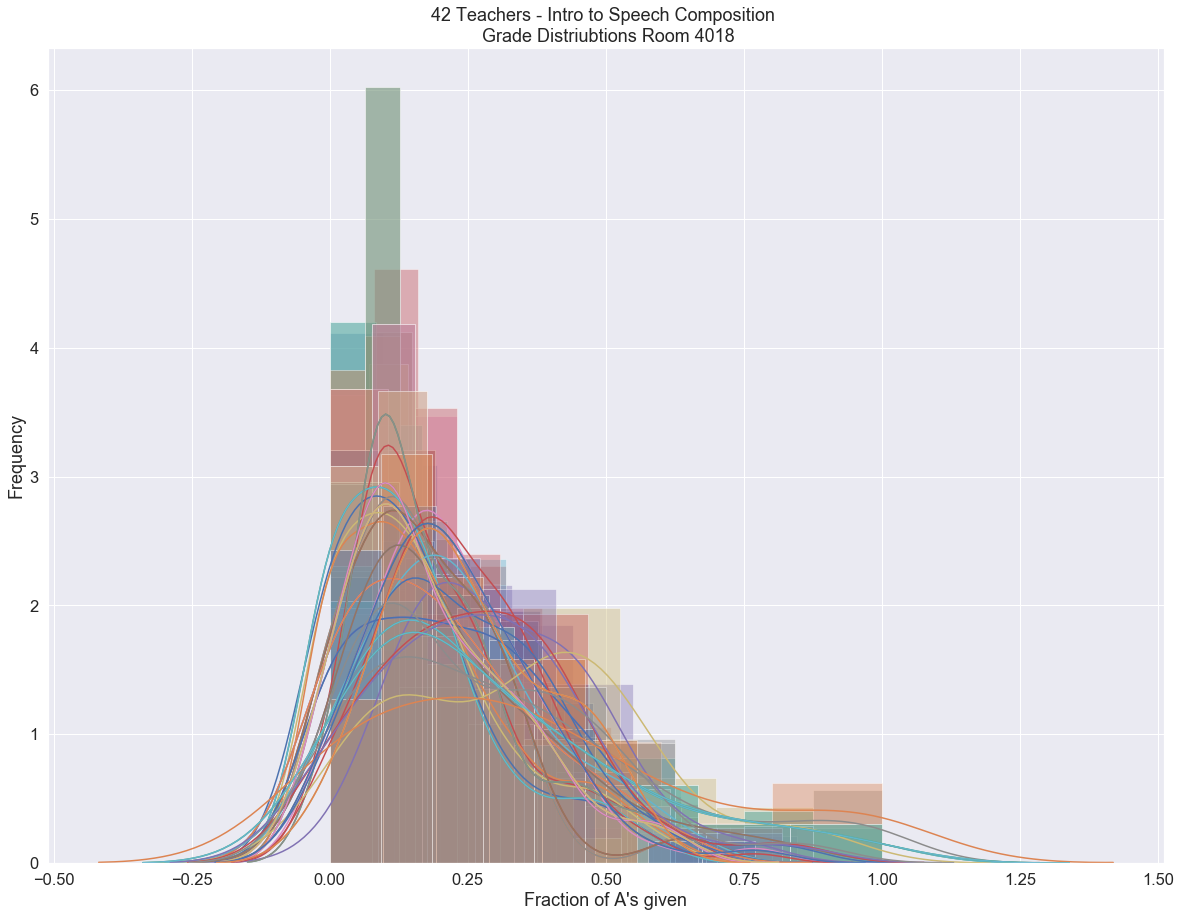

In [29]:
#Seaborn distplot of room 4018 Speech Composition
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4018.shape[0]):
    sns.distplot(df_4018.iloc[row]['A'],  ax = ax)
    
ax.set_title("42 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4018")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")

### Now looking at the two classrooms with sections and teachers all together

In [30]:

Speech_4013 = []
for row in range(df_4013.shape[0]):
    Speech_4013+=list(df_4013.iloc[row]['A'])

Speech_4018 = []
for row in range(df_4018.shape[0]):
    Speech_4018+=list(df_4018.iloc[row]['A'])

Text(0.5, 0, "Fraction of A's given")

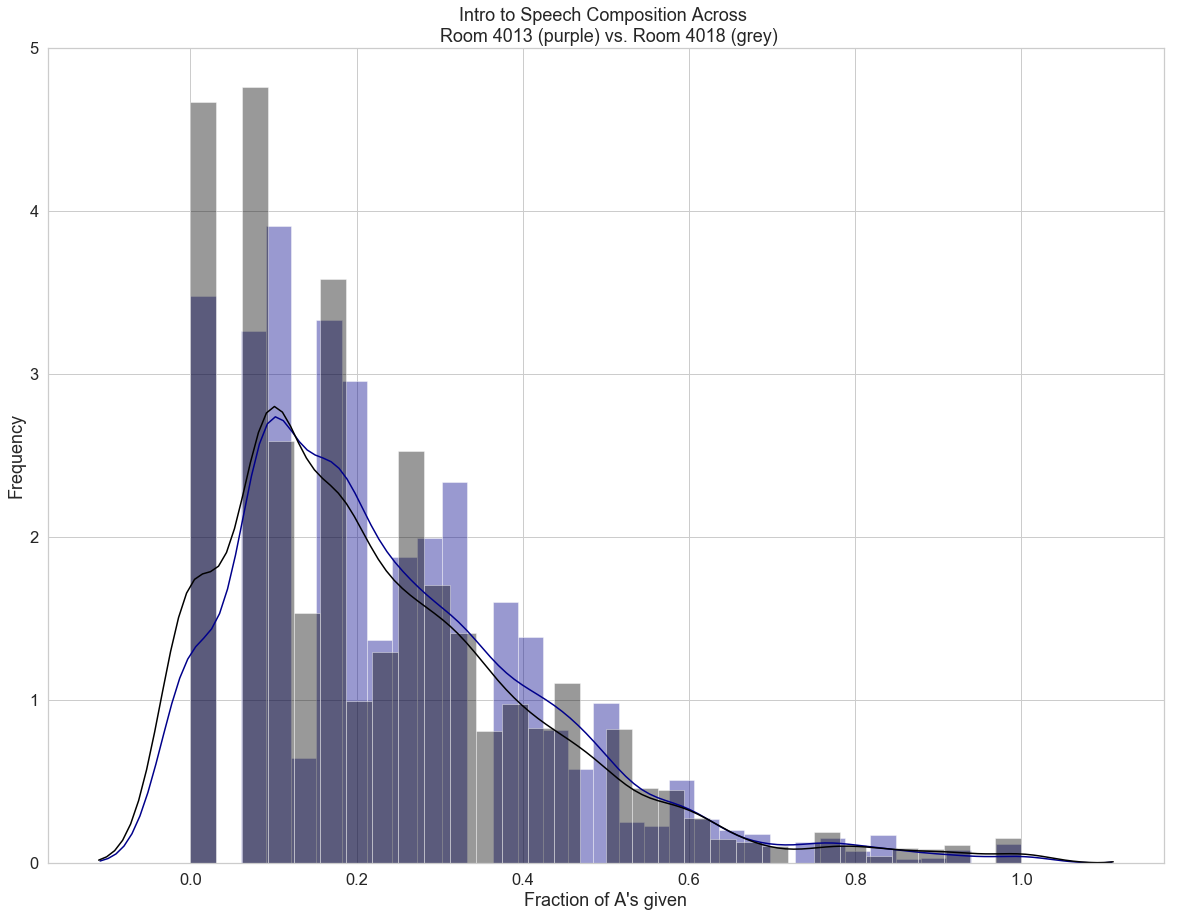

In [31]:
#Seaborn distplot of room 4013 vs room 4018 Speech Composition 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Speech_4013,  ax = ax, color='darkblue')
sns.distplot(Speech_4018,  ax = ax, color='black')
    
ax.set_title("Intro to Speech Composition Across \n Room 4013 (purple) vs. Room 4018 (grey)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")

In [32]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Speech_4013
y = Speech_4018
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {ttest[1]}')
print('The test rejects the null at the .05 level of significance.')
print('The effect size is : ', (np.array(Speech_4013).mean()-np.array(Speech_4018).mean()))

The p-value for the two sided independent t test is:  0.0012359938987117538
The test rejects the null at the .05 level of significance.
The effect size is :  0.01385333037773917


In [33]:
#Get rid of rows that represent teachers that do not teach in both classrooms
df_4018 = df_4018[df_4018.instructor_id.isin(instructors_4013)]
instructors_4018 = list(df_4018['instructor_id'])
df_4013 = df_4013[df_4013.instructor_id.isin(instructors_4018)]


Text(0.5, 0, "Percentage of A's given")

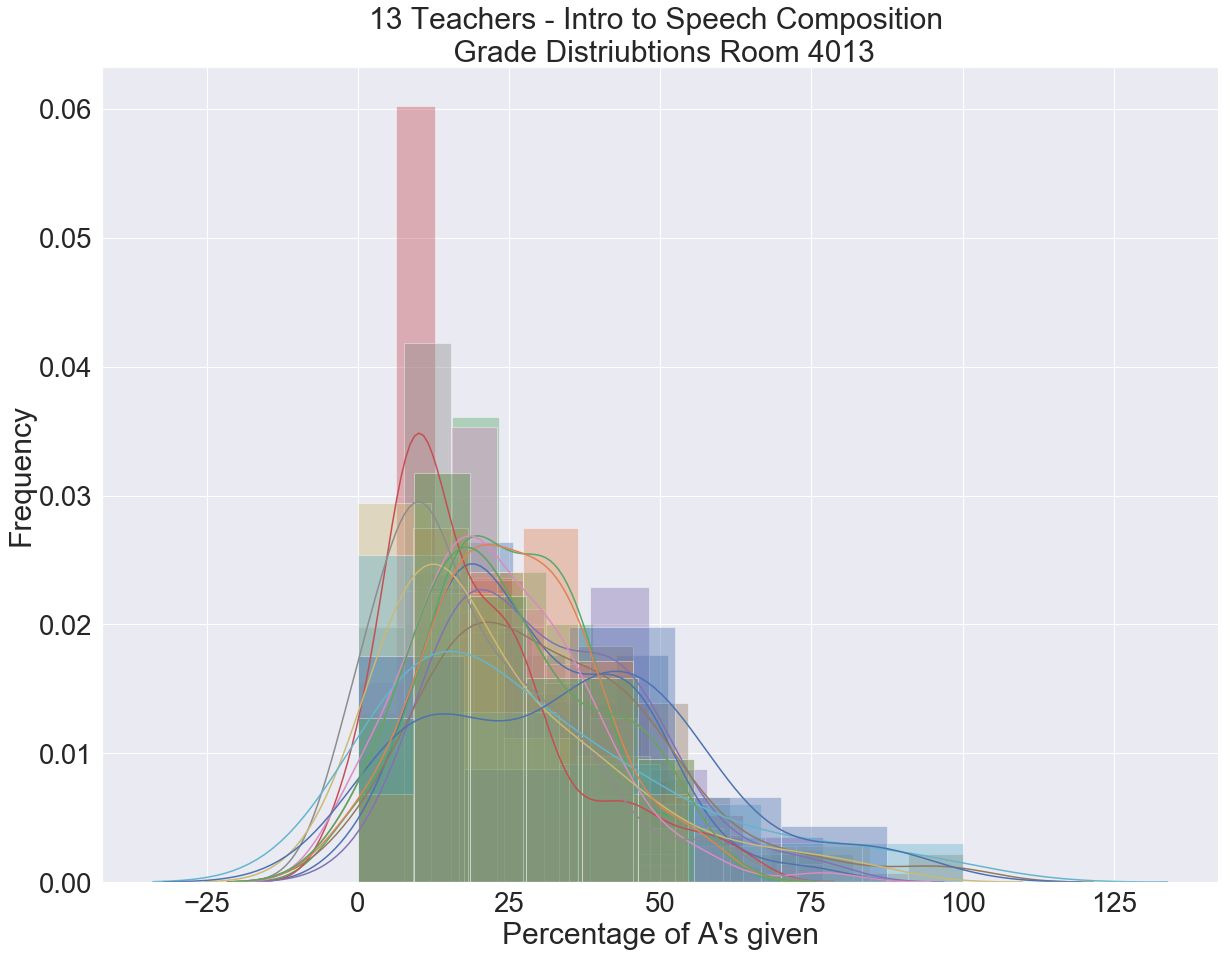

In [102]:
#Seaborn distplot of room 4013 Speech Composition with only the teachers also teaching in 4018
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4013.shape[0]):
    sns.distplot(df_4013.iloc[row]['A']*100,  ax = ax)
    
ax.set_title("13 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4013")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's given")

Text(0.5, 0, "Percentage of A's Given")

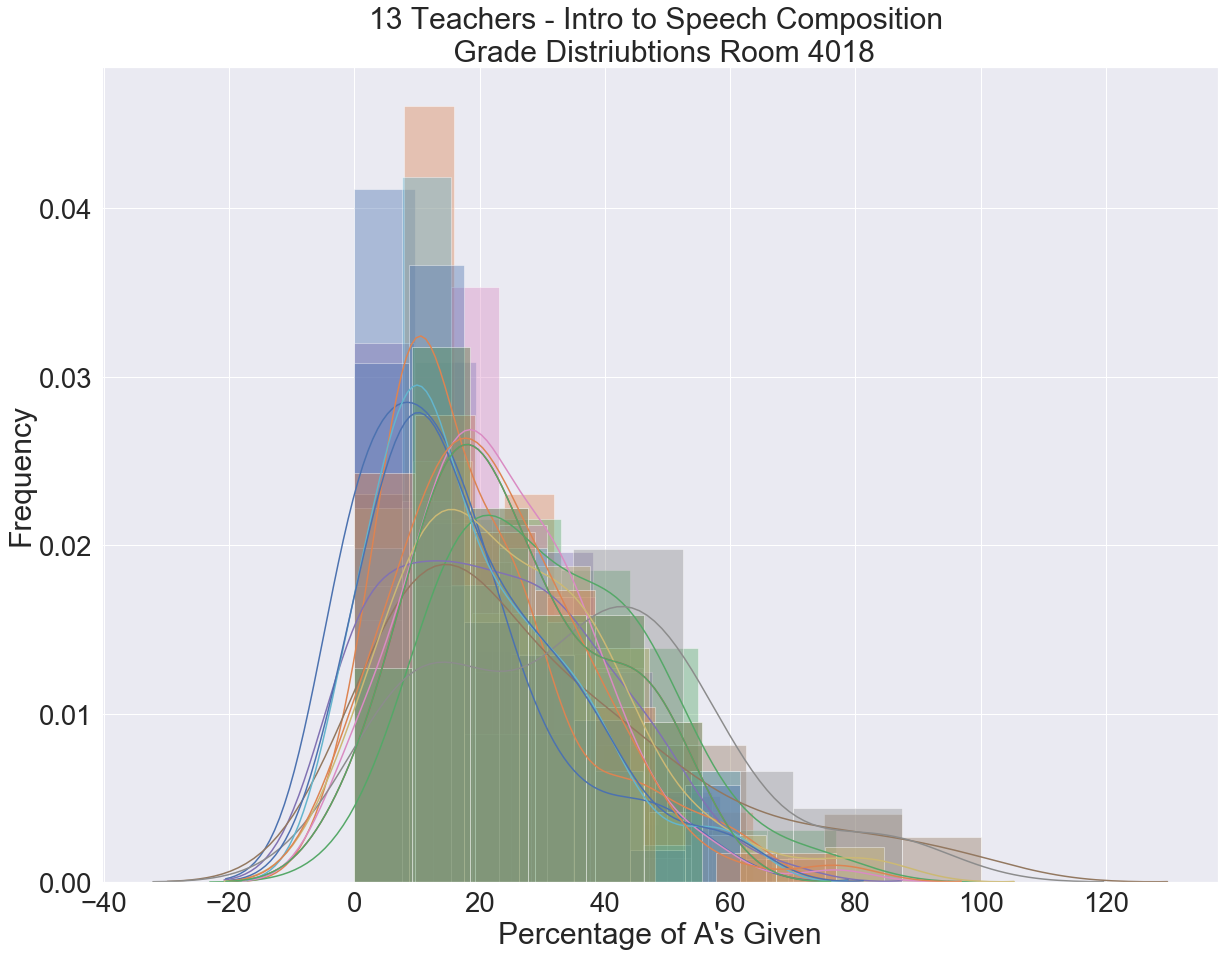

In [103]:
#Seaborn distplot of room 4018 Speech Composition with only the teachers also teaching in 4018
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4018.shape[0]):
    sns.distplot(df_4018.iloc[row]['A']*100,  ax = ax)
    
ax.set_title("13 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4018")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's Given")

In [104]:
#Melt all the sections/teachers into on array
Speech_4013 = []
for row in range(df_4013.shape[0]):
    Speech_4013+=list(df_4013.iloc[row]['A']*100)

Speech_4018 = []
for row in range(df_4018.shape[0]):
    Speech_4018+=list(df_4018.iloc[row]['A']*100)

Text(0.5, 0, "Percentage of A's given")

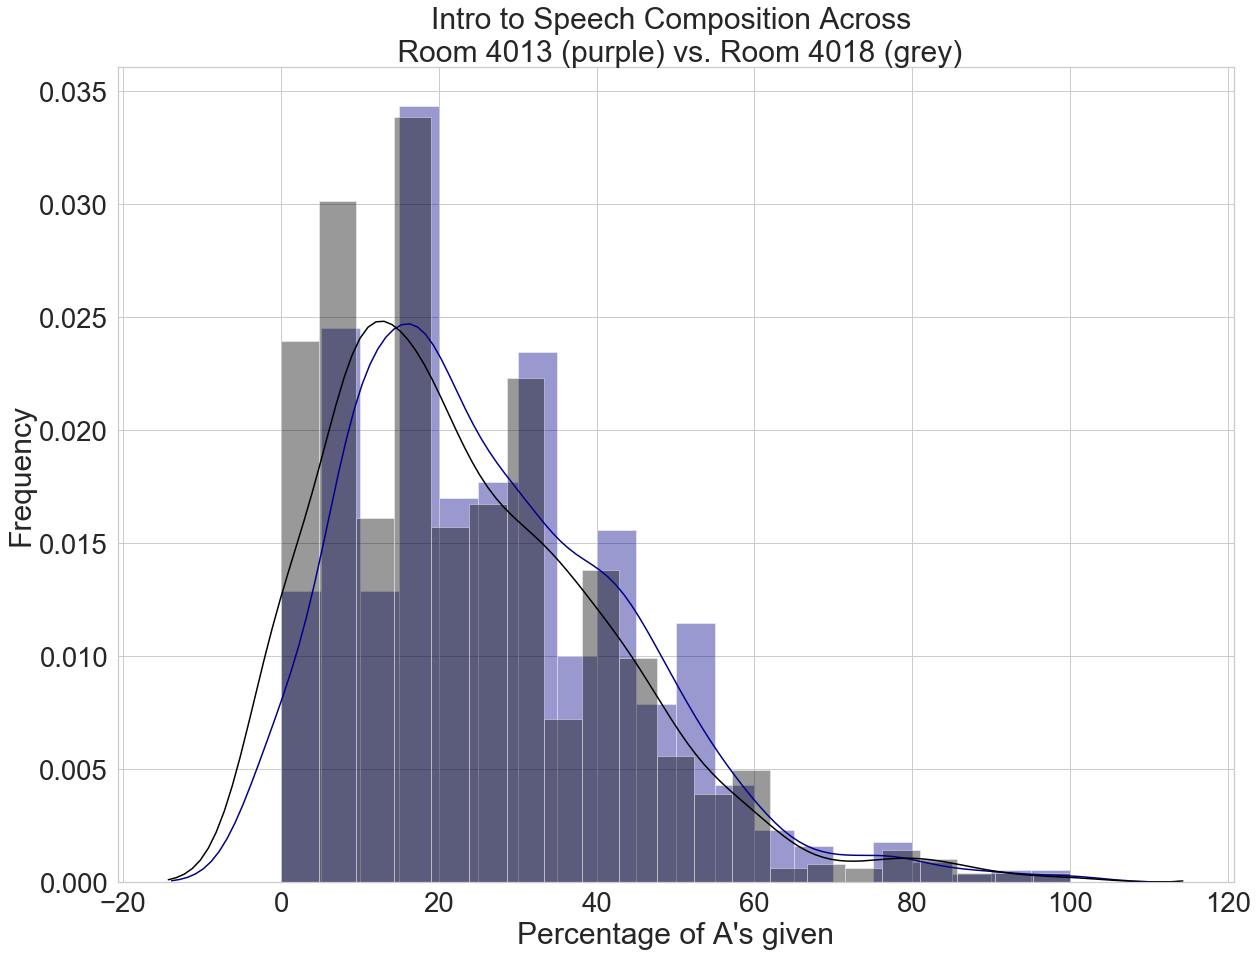

In [105]:
#Seaborn distplot of room 4013 vs room 4018 Speech Composition with only the teachers that teach in both classrooms
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Speech_4013,  ax = ax, color='darkblue')
sns.distplot(Speech_4018,  ax = ax, color='black')
    
ax.set_title("Intro to Speech Composition Across \n Room 4013 (purple) vs. Room 4018 (grey)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's given")

In [107]:
print('The mean of room 2170 is: ', round(np.array(Speech_4013).mean(),2), '%\nThe mean of room 2190 is: ', round(np.array(Speech_4018).mean(),2),'%')


The mean of room 2170 is:  26.48 %
The mean of room 2190 is:  23.8 %


In [38]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Speech_4013
y = Speech_4018
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {ttest[1]}')
print('The test rejects the null at the .05 level of significance.')

print('The effect size is: ', np.array(Speech_4013).mean()-np.array(Speech_4018).mean())


The p-value for the two sided independent t test is:  0.0005834813532141896
The test rejects the null at the .05 level of significance.
The effect size is:  0.026780696431120438


Finally we will investigate whether students perform better on average in classes taught at 8 AM or 1 PM

Bringing in Data from Sqlite Datatbase. 



In [2]:
conn = sqlite3.connect('database.sqlite3')
c = conn.cursor()

In [3]:
c.execute('''SELECT * FROM grade_distributions JOIN sections using (course_offering_uuid) JOIN schedules on sections.schedule_uuid = schedules.uuid''')
df = pd.DataFrame(c.fetchall())
df.columns = [i[0] for i in c.description]
df.shape

(2077516, 33)

Cleaning up the dataframe

In [4]:
df_dropped = df.drop(columns=['mon', 'tues', 'wed', 'thurs', 'fri','uuid', 'other_count', 'sat','sun','room_uuid', 'section_number', 'n_count', 'p_count', 'nw_count', 'u_count', 's_count', 'i_count', 'nr_count', 'number', 'schedule_uuid', 'end_time'], axis=1)

In [5]:
df_dropped.head()

,course_offering_uuid,c_count,f_count,cr_count,bc_count,d_count,ab_count,a_count,b_count,section_type,start_time
0,344b3ebe-da7e-314c-83ed-9425269695fd,0,0,0,0,0,0,105,0,FLD,-1
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,0,0,0,0,0,0,158,0,FLD,-1
2,ea3b717c-d66b-30dc-8b37-964d9688295f,3,0,0,0,0,12,139,2,FLD,-1
3,ea3b717c-d66b-30dc-8b37-964d9688295f,3,0,0,0,0,12,139,2,FLD,-1
4,ea3b717c-d66b-30dc-8b37-964d9688295f,3,0,0,0,0,12,139,2,FLD,-1


Transforming the Start Time into hours.

In [6]:
df_dropped["start_time"] = df_dropped["start_time"].apply(
    lambda x: int(x) / 60
)
df_dropped = df_dropped.dropna()
sorted(pd.unique(df_dropped["start_time"]))

[-0.016666666666666666,
 0.5,
 1.1666666666666667,
 2.5,
 5.5,
 6.0,
 6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12

Removed start times that start before 6:00 AM

In [7]:
df_dropped = df_dropped.loc[df_dropped["start_time"] > 6]
sorted(pd.unique(df_dropped["start_time"]))

[6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12.083333333333334,
 12.166666666666666,
 12.25,
 12.333333333333334,
 

Created a new column that shows what hour each class started within

In [8]:
df_dropped["hour_within"] = df_dropped["start_time"].apply(lambda x: x // 1)

In [9]:
df_dropped.head()

,course_offering_uuid,c_count,f_count,cr_count,bc_count,d_count,ab_count,a_count,b_count,section_type,start_time,hour_within
165,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,0,46,0,LAB,8.833333,8.0
166,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,0,41,0,LAB,8.833333,8.0
167,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,5,13,1,LAB,8.833333,8.0
168,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,6,11,2,LAB,8.833333,8.0
169,a71789f0-09d9-3374-bd21-04a719a62af8,0,0,0,0,0,0,46,0,LAB,11.000000,11.0


In [10]:
important_grades = [
    "f_count",
    "d_count",
    "c_count",
    "bc_count",
    "b_count",
    "ab_count",
    "a_count",
]

# course_offering_uuid is needed for a later join
df_dropped = df_dropped[[*important_grades, "start_time", "course_offering_uuid"]]
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766724 entries, 165 to 2077513
Data columns (total 9 columns):
f_count                 766724 non-null object
d_count                 766724 non-null object
c_count                 766724 non-null object
bc_count                766724 non-null object
b_count                 766724 non-null object
ab_count                766724 non-null object
a_count                 766724 non-null object
start_time              766724 non-null float64
course_offering_uuid    766724 non-null object
dtypes: float64(1), object(8)
memory usage: 58.5+ MB


Converted the grades from objects to floats

In [11]:
df_dropped[important_grades] = df_dropped[important_grades].apply(lambda x: pd.to_numeric(x))
df_dropped = df_dropped.dropna()


Turned grades into an average GPA for the class and ratio for each grade

In [12]:
grades = df_dropped[important_grades].copy()
df_dropped["total"] = grades.sum(axis=1)
important_grades_ratios = list(map(lambda x: x + "_ratio", important_grades))
df_dropped[important_grades_ratios] = grades[important_grades].apply(lambda x: x / df_dropped["total"])

In [13]:
gpa_scale = np.array([0, 1, 2, 2.5, 3, 3.5, 4], dtype="float32")
df_dropped["gpa"] = df_dropped[important_grades_ratios].apply(lambda x: np.dot(x, gpa_scale), axis=1)

In [14]:
df_dropped["hour_within"] = df_dropped["start_time"].apply(lambda x: x // 1)

In [15]:
df_dropped.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
165,0,0,0,0,0,0,46,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
166,0,0,0,0,0,0,41,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
167,0,0,0,0,1,5,13,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,8.0
168,0,0,0,0,2,6,11,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,8.0
169,0,0,0,0,0,0,46,11.000000,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,11.0


In [16]:
# df_dropped = df_dropped[['course_offering_uuid','hour_within', 'gpa', 'f_count', 'f_count_ratio', 'a_count', 'a_count_ratio','d_count', 'c_count', 'bc_count', 'b_count', 'ab_count']]

In [17]:
df_dropped.shape

(766724, 19)

In [18]:
gpa_scale = np.array([0, 1, 2, 2.5, 3, 3.5, 4], dtype="float32")
df_dropped["gpa"] = df_dropped[important_grades_ratios].apply(lambda x: np.dot(x, gpa_scale), axis=1)

In [19]:
gpa_within_hour = df_dropped[["gpa", "hour_within"]].groupby("hour_within") 

Isolated all the classes that start within the hour of 8:00 AM

In [20]:
df_8 = df_dropped.loc[df_dropped["hour_within"] == 8]

In [21]:
df_8.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
165,0,0,0,0,0,0,46,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
166,0,0,0,0,0,0,41,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
167,0,0,0,0,1,5,13,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,8.0
168,0,0,0,0,2,6,11,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,8.0
336,0,0,0,0,0,2,23,8.833333,cb14977e-d147-3110-8bf0-83c363730609,25,0.0,0.0,0.0,0.0,0.000000,0.080000,0.920000,3.960000,8.0


Isolated all the classes that start within the hour of 1:00 PM

In [22]:
df_2 = df_dropped.loc[df_dropped["hour_within"] == 13]

In [23]:
df_2.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
173,0,0,0,0,0,0,46,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,13.0
174,0,0,0,0,0,0,41,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,13.0
175,0,0,0,0,1,5,13,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,13.0
176,0,0,0,0,2,6,11,13.333333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,13.0
181,0,0,0,0,0,2,38,13.333333,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,40,0.0,0.0,0.0,0.0,0.000000,0.050000,0.950000,3.975000,13.0


In [24]:
# df_1 = df_1[['course_offering_uuid','hour_within', 'gpa', 'f_count', 'f_count_ratio', 'a_count', 'a_count_ratio','d_count', 'c_count', 'bc_count', 'b_count', 'ab_count']]

In [25]:
df_2.describe()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
count,123270.000000,123270.00000,123270.000000,123270.000000,123270.000000,123270.000000,123270.000000,123270.000000,123270.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,113047.000000,123270.0
mean,0.672191,1.37357,5.066083,4.744561,12.446281,9.790549,15.200089,13.250758,49.293324,0.008920,0.014261,0.056786,0.068923,0.221735,0.228909,0.400467,3.368394,13.0
std,2.088344,4.11415,12.872938,10.723963,24.166786,16.560322,27.843329,0.155317,80.416239,0.022771,0.030250,0.077460,0.077348,0.164511,0.157965,0.268250,0.375679,0.0
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.208333,13.0
25%,0.000000,0.00000,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.111111,0.200000,3.103448,13.0
50%,0.000000,0.00000,0.000000,1.000000,4.000000,5.000000,7.000000,13.333333,19.000000,0.000000,0.000000,0.011494,0.052239,0.222222,0.210526,0.315789,3.352564,13.0
75%,0.000000,1.00000,2.000000,3.000000,9.000000,9.000000,16.000000,13.333333,35.000000,0.000000,0.013158,0.090909,0.116788,0.318182,0.333333,0.555556,3.666667,13.0
max,37.000000,62.00000,139.000000,125.000000,219.000000,234.000000,704.000000,13.916667,716.000000,0.500000,0.545455,1.000000,0.555556,1.000000,1.000000,1.000000,4.000000,13.0


In [26]:
df_2['gpa'].describe()

count    113047.000000
mean          3.368394
std           0.375679
min           1.208333
25%           3.103448
50%           3.352564
75%           3.666667
max           4.000000
Name: gpa, dtype: float64

In [27]:
# df_8 = df_8[['course_offering_uuid','hour_within', 'gpa', 'f_count', 'f_count_ratio', 'a_count', 'a_count_ratio','d_count', 'c_count', 'bc_count', 'b_count', 'ab_count']]

In [28]:
df_8['gpa'].describe()

count    80187.000000
mean         3.371119
std          0.384760
min          1.000000
25%          3.099206
50%          3.346154
75%          3.678571
max          4.000000
Name: gpa, dtype: float64

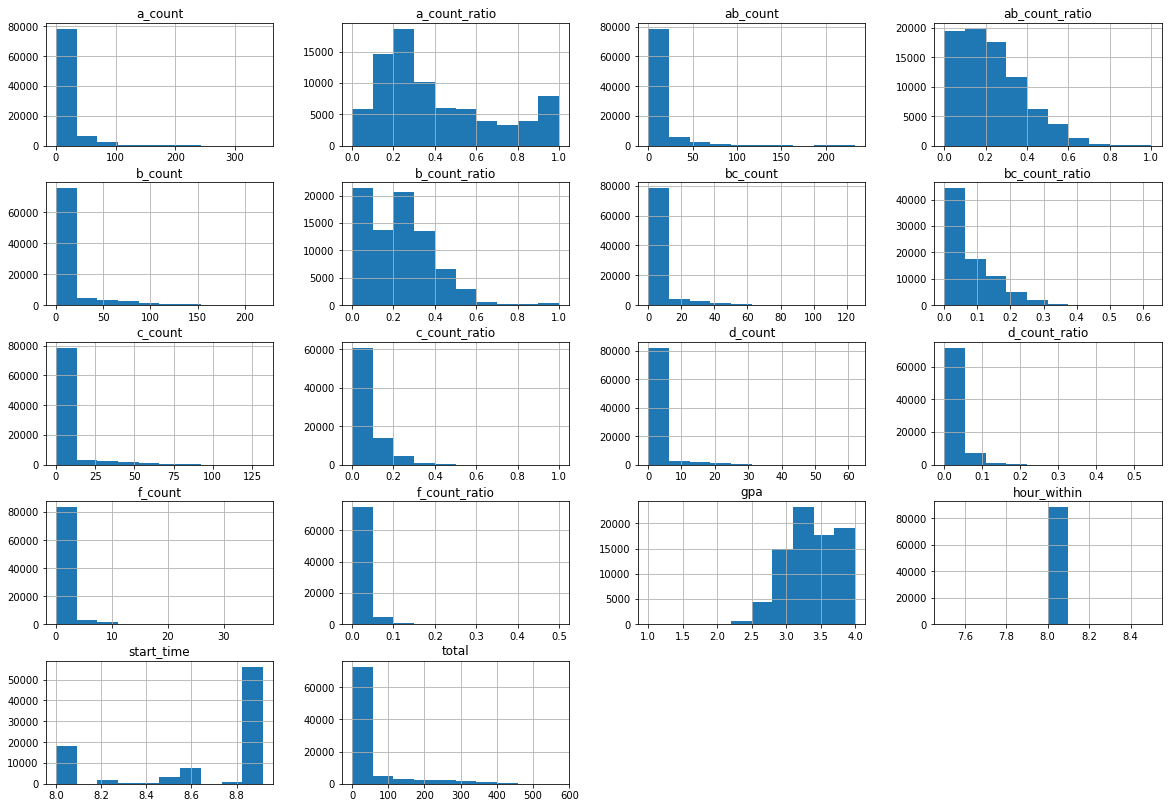

In [29]:
%matplotlib inline

df_8.hist(bins=10, figsize  = [20, 14])
plt.title('Grades for 8:00 AM Classes')
plt.show()

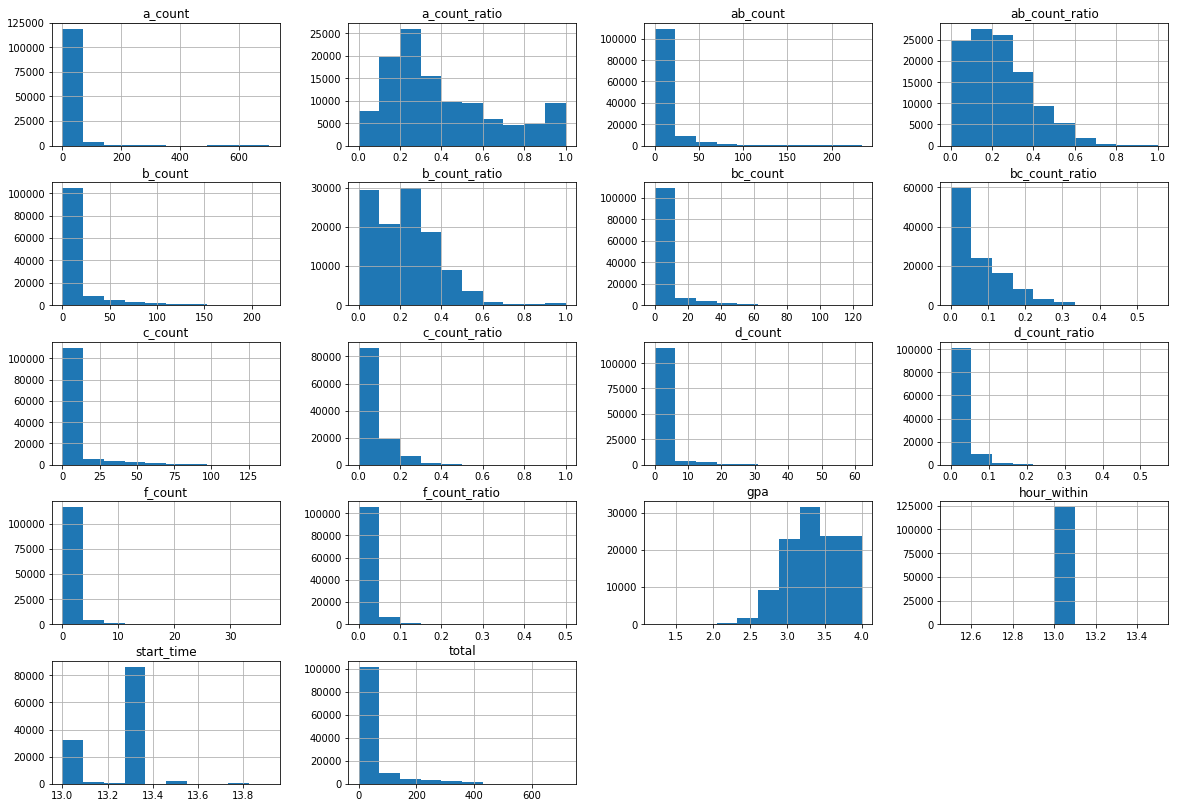

In [30]:
%matplotlib inline

df_2.hist(bins=10, figsize  = [20, 14])
plt.title('Grades for 1:00 PM Classes')
plt.show()

In [31]:
pass_fail_ratio_1 = (df_2.f_count_ratio.sum() + df_2.d_count_ratio.sum()) / (df_2.a_count_ratio.sum() + df_2.ab_count_ratio.sum() + df_2.b_count_ratio.sum() + df_2.bc_count_ratio.sum() + df_2.c_count_ratio.sum() + df_2.d_count_ratio.sum() + df_2.f_count_ratio.sum())


In [32]:
pass_fail_ratio_8 = (df_8.f_count_ratio.sum() + df_8.d_count_ratio.sum()) / (df_8.a_count_ratio.sum() + df_8.ab_count_ratio.sum() + df_8.b_count_ratio.sum() + df_8.bc_count_ratio.sum() + df_8.c_count_ratio.sum() + df_8.d_count_ratio.sum() + df_8.f_count_ratio.sum())


In [33]:
pass_fail_ratio_1

0.023180483365384207

In [34]:
pass_fail_ratio_8

0.0226003779895223

In [35]:
df_2.describe().loc['mean']

f_count            0.672191
d_count            1.373570
c_count            5.066083
bc_count           4.744561
b_count           12.446281
ab_count           9.790549
a_count           15.200089
start_time        13.250758
total             49.293324
f_count_ratio      0.008920
d_count_ratio      0.014261
c_count_ratio      0.056786
bc_count_ratio     0.068923
b_count_ratio      0.221735
ab_count_ratio     0.228909
a_count_ratio      0.400467
gpa                3.368394
hour_within       13.000000
Name: mean, dtype: float64

In [36]:
df_8.describe().loc['mean']

f_count            0.663113
d_count            1.423656
c_count            5.291930
bc_count           4.921381
b_count           12.295020
ab_count           9.361177
a_count           14.353537
start_time         8.612979
total             48.309813
f_count_ratio      0.008479
d_count_ratio      0.014121
c_count_ratio      0.057993
bc_count_ratio     0.068289
b_count_ratio      0.223400
ab_count_ratio     0.221563
a_count_ratio      0.406155
gpa                3.371119
hour_within        8.000000
Name: mean, dtype: float64

In [37]:
df_dropped_2 = df_2[['f_count_ratio', 'd_count_ratio', 'c_count_ratio','bc_count_ratio','b_count_ratio','ab_count_ratio', 'a_count_ratio']]

Text(0.5, 1.0, 'Grade Percentage for 1:00 PM Classes')

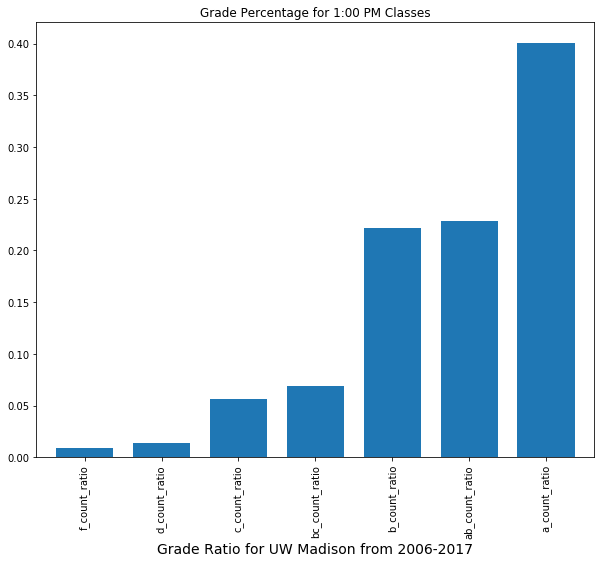

In [38]:
df_dropped_2.describe().loc['mean'].plot.bar(width = 0.75, figsize = (10,8))
plt.xlabel('Grade Ratio for UW Madison from 2006-2017',fontsize=14)
plt.title('Grade Percentage for 1:00 PM Classes')

In [39]:
df_dropped_8 = df_8[['f_count_ratio', 'd_count_ratio', 'c_count_ratio','bc_count_ratio','b_count_ratio','ab_count_ratio', 'a_count_ratio']]

Text(0.5, 1.0, 'Grade Percentage for 8:00 AM Classes')

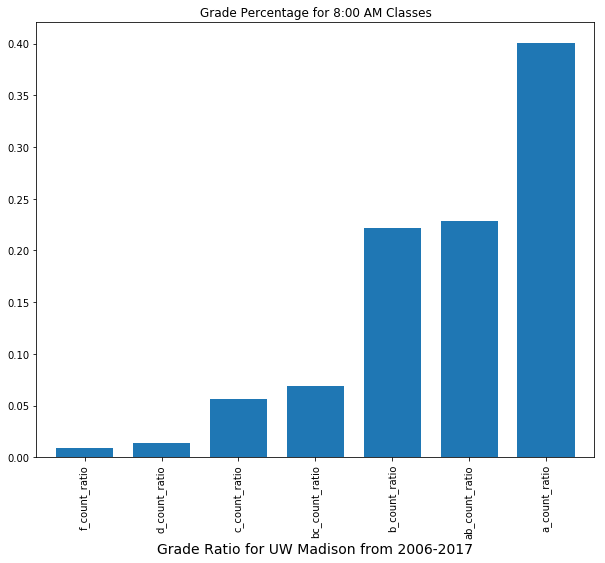

In [40]:
df_dropped_2.describe().loc['mean'].plot.bar(width = 0.75, figsize = (10,8))
plt.xlabel('Grade Ratio for UW Madison from 2006-2017',fontsize=14)
plt.title('Grade Percentage for 8:00 AM Classes')

Converted F's into an array to run a Z-Test

In [41]:
x1 = df_2['f_count'].as_matrix(columns=None)

In [42]:
x2 = df_8['f_count'].as_matrix(columns=None)

In [43]:
import statsmodels as sm 

In [44]:
sm.stats.weightstats.ztest(x1, x2, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)

(0.9736438374568975, 0.33023341210544765)

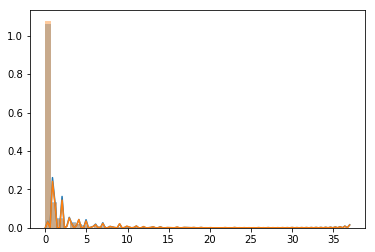

In [45]:
sns.distplot(x1)
sns.distplot(x2)
             
            

Text(0.5, 0, 'Percent Failures')

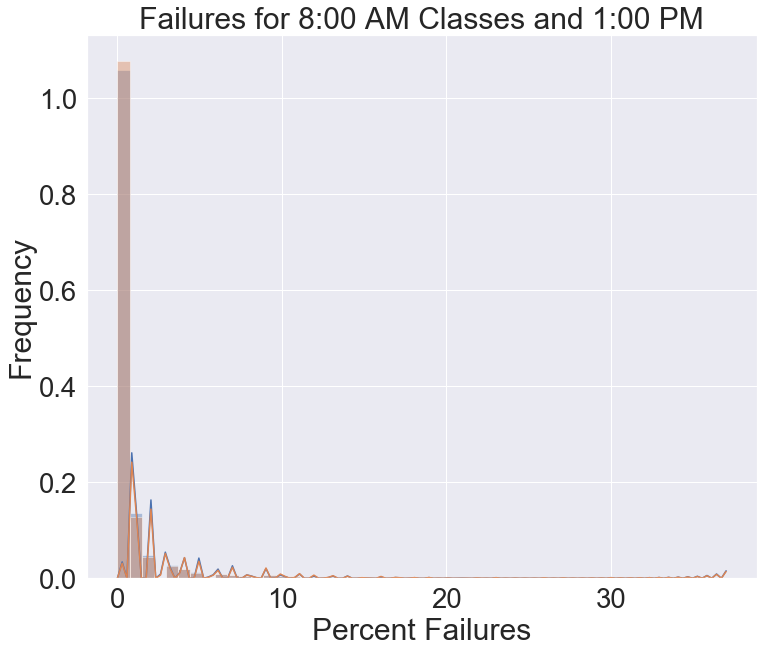

In [46]:
to_graph =  [x1, x2]

#Seaborn distplot of room 2170 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)

fig, ax = plt.subplots(figsize=(12,10))
for graph in to_graph:
    sns.distplot(graph,  ax = ax)
    
ax.set_title("Failures for 8:00 AM Classes and 1:00 PM")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent Failures")